### Identify Missing Values

In [ ]:
import pandas as pd
# Load the dataset
df = pd.read_csv('merged_dataset.csv')

# Identify missing values in each column
missing_values = df.isnull().sum()

# Display columns with missing values
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

DRQSDT5     19580
DRQSDT6     19576
DRD370JQ    19559
DRD370PQ    19558
DRD350JQ    19551
            ...  
FIAPROXY      196
FIALANG       196
DMDHRMAR      130
DMDCITZN        6
SIAPROXY        1
Length: 201, dtype: int64

### Dropping columns which has more then 50% missing values

In [ ]:
# Drop columns with more than 50% missing values
threshold = int(df.shape[0] * 0.5)
df_cleaned = df.dropna(axis=1, thresh=threshold)

# Show the shape of the cleaned dataset and list the remaining columns
df_cleaned_shape = df_cleaned.shape
remaining_columns = df_cleaned.columns

df_cleaned_shape, remaining_columns

((19580, 160),
 Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1',
        'RIDRETH3', 'RIDEXMON', 'DMQMILIZ', 'DMDBORN4',
        ...
        'DRD370U', 'DRD370V', 'RXDUSE', 'RXDDRUG', 'RXDDRGID', 'RXQSEEN',
        'RXDDAYS', 'RXDRSC1', 'RXDRSD1', 'RXDCOUNT'],
       dtype='object', length=160))

### Imputing the records using mean for numerical columns and mode for categorical columns

In [ ]:
# Separate numerical and categorical columns
numerical_columns = df_cleaned.select_dtypes(include=['number']).columns
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

# Impute missing values for numerical columns with the mean
for column in numerical_columns:
    df_cleaned[column].fillna(df_cleaned[column].mean(), inplace=True)

# Impute missing values for categorical columns with the mode (most frequent value)
for column in categorical_columns:
    df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)

# Verify that there are no remaining missing values
remaining_missing_values = df_cleaned.isnull().sum().sum()

remaining_missing_values

<ipython-input-16-d11832f20886>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column].fillna(df_cleaned[column].mean(), inplace=True)
<ipython-input-16-d11832f20886>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)


0

### Handing Duplicate Records

In [ ]:
# Remove duplicate rows
df_cleaned.drop_duplicates(inplace=True)

# Check for duplicated SEQN values (patient IDs)
duplicated_seqn = df_cleaned[df_cleaned['SEQN'].duplicated()]

# Output the number of duplicated SEQN values and the duplicated rows themselves if any
num_duplicated_seqn = duplicated_seqn.shape[0]
duplicated_seqn.head(), num_duplicated_seqn

<ipython-input-17-a8f51cd2b4cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop_duplicates(inplace=True)


(    SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDRETH1  RIDRETH3  \
 1  73557         8         2         1        69         4         4   
 3  73558         8         2         1        54         3         3   
 4  73558         8         2         1        54         3         3   
 5  73558         8         2         1        54         3         3   
 7  73559         8         2         1        72         3         3   
 
    RIDEXMON  DMQMILIZ  DMDBORN4  ...   DRD370U  DRD370V  RXDUSE  \
 1       1.0       1.0         1  ...  1.937108      2.0       1   
 3       1.0       2.0         1  ...  2.000000      2.0       1   
 4       1.0       2.0         1  ...  2.000000      2.0       1   
 5       1.0       2.0         1  ...  2.000000      2.0       1   
 7       2.0       1.0         1  ...  1.937108      2.0       1   
 
             RXDDRUG  RXDDRGID  RXQSEEN  RXDDAYS  RXDRSC1  \
 1           INSULIN    d00262      2.0   1460.0      E11   
 3  INSULIN GLARGINE    d045

### Outlier Detection

In [ ]:
from scipy.stats import zscore
import numpy as np

# Identify numerical columns for outlier detection
numerical_columns = df_cleaned.select_dtypes(include=['number']).columns

# Initialize a dictionary to store the upper limits for capping
upper_limits = {}

# Detect outliers using z-score and handle them
for column in numerical_columns:
    # Calculate the z-score for each value in the column
    z_scores = zscore(df_cleaned[column])

    # Identify the outliers (those with a z-score greater than 3 or less than -3)
    outliers = df_cleaned[np.abs(z_scores) > 3]

    if not outliers.empty:
        # Calculate the upper limit for capping
        upper_limit = df_cleaned[column].mean() + 3 * df_cleaned[column].std()
        upper_limits[column] = upper_limit

        # Cap the outliers
        df_cleaned[column] = np.where(df_cleaned[column] > upper_limit, upper_limit, df_cleaned[column])

        # Apply log transformation for skewed data (if appropriate)
        if df_cleaned[column].skew() > 1:
            df_cleaned[column] = np.log1p(df_cleaned[column])

# Output the columns where outliers were detected and handled, and the corresponding upper limits used for capping
upper_limits

<ipython-input-18-8774865cbbdc>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column] = np.where(df_cleaned[column] > upper_limit, upper_limit, df_cleaned[column])
<ipython-input-18-8774865cbbdc>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column] = np.log1p(df_cleaned[column])


{'DMQMILIZ': 2.7729336309689883,
 'DMDBORN4': 5.346210890763962,
 'DMDCITZN': 2.078307430843853,
 'DMDEDUC2': 6.6701018512068435,
 'DMDMARTL': 10.377508043836407,
 'SIALANG': 1.9172973402711633,
 'SIAINTRP': 2.4920964741862646,
 'FIALANG': 1.687424231867717,
 'FIAPROXY': 2.1232141854906077,
 'FIAINTRP': 2.4500518469347803,
 'MIALANG': 1.6495353875190126,
 'MIAPROXY': 2.2723130084858814,
 'MIAINTRP': 2.448465131770084,
 'AIALANGA': 1.8815110639777637,
 'DMDHHSZA': 2.402638772861212,
 'DMDHHSZB': 3.9658288738660907,
 'DMDHRBR4': 9.87750311706203,
 'DMDHREDU': 7.182785954970731,
 'DMDHRMAR': 17.961036762212842,
 'DMDHSEDU': 6.335915363427571,
 'WTINT2YR': 122404.16045231058,
 'WTMEC2YR': 125614.42093606468,
 'INDHHIN2': 50.14445091340649,
 'INDFMIN2': 49.09395847011714,
 'WTDRD1': 150204.45845090217,
 'WTDR2D': 195874.95080632463,
 'DRABF': 2.2438708034147172,
 'DRDINT': 2.7635127889366013,
 'DR1DBIH': 49.195927970340804,
 'DR1LANG': 2.691292955407448,
 'DR1MNRSP': 4.87708434041877,
 'DR1

### Feature Engineering and Removing Irrelevant Columns

In [ ]:
import pandas as pd
import numpy as np

# Assuming df_cleaned is the DataFrame after initial cleaning steps

# Step 1: Remove Irrelevant Columns

# Remove the 'SEQN' column as it is a unique identifier and doesn't contribute to the model
if 'SEQN' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['SEQN'])

# Step 2: Remove columns with low variance (numerical columns only)
# Calculate variance of each numerical column
numerical_columns = df_cleaned.select_dtypes(include=['number']).columns
variance = df_cleaned[numerical_columns].var()
low_variance_columns = variance[variance < 0.01].index

# Drop columns with low variance
df_cleaned = df_cleaned.drop(columns=low_variance_columns)

# Step 3: Feature Engineering (creating interaction terms as an example)

# Example interaction: Age * Gender (if gender is encoded numerically)
if 'RIDAGEYR' in df_cleaned.columns and 'RIAGENDR' in df_cleaned.columns:
    df_cleaned = pd.concat([df_cleaned, df_cleaned['RIDAGEYR'] * df_cleaned['RIAGENDR']], axis=1)
    df_cleaned.rename(columns={0: 'Age_Gender_Interaction'}, inplace=True)

# Step 4: Drop Highly Correlated Features

# Ensure numerical columns are still present after previous operations
numerical_columns = [col for col in numerical_columns if col in df_cleaned.columns]

# Calculate correlation matrix (numerical columns only)
correlation_matrix = df_cleaned[numerical_columns].corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index of features with correlation greater than 0.9
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
df_cleaned = df_cleaned.drop(columns=highly_correlated_features)

# Output the shape of the cleaned and engineered dataset and the first few columns
df_cleaned_shape = df_cleaned.shape
df_cleaned_head = df_cleaned.head()

df_cleaned_shape, df_cleaned_head


((19560, 122),
    RIAGENDR  RIDAGEYR  RIDRETH1  RIDEXMON  DMQMILIZ  DMDBORN4  DMDCITZN  \
 0         1        69         4       1.0       1.0  0.693147  0.693147   
 1         1        69         4       1.0       1.0  0.693147  0.693147   
 2         1        54         3       1.0       2.0  0.693147  0.693147   
 3         1        54         3       1.0       2.0  0.693147  0.693147   
 4         1        54         3       1.0       2.0  0.693147  0.693147   
 
    DMDEDUC2  DMDMARTL   SIALANG  ...   DRD370U  RXDUSE           RXDDRUG  \
 0       3.0  1.609438  0.693147  ...  1.937108     1.0             99999   
 1       3.0  1.609438  0.693147  ...  1.937108     1.0           INSULIN   
 2       3.0  0.693147  0.693147  ...  2.000000     1.0        GABAPENTIN   
 3       3.0  0.693147  0.693147  ...  2.000000     1.0  INSULIN GLARGINE   
 4       3.0  0.693147  0.693147  ...  2.000000     1.0        OLMESARTAN   
 
    RXDDRGID   RXQSEEN   RXDDAYS  RXDRSC1  \
 0    d00732  0.77

### Data Type Conversion

In [ ]:
# Step 5: Data Type Conversions

# Convert columns that should be numeric but might be object
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == 'object':
        try:
            df_cleaned[column] = pd.to_numeric(df_cleaned[column])
        except ValueError:
            pass  # Ignore columns that can't be converted

# Convert categorical columns to 'category' type
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_columns] = df_cleaned[categorical_columns].astype('category')

# Convert binary columns to boolean
for column in df_cleaned.columns:
    if sorted(df_cleaned[column].unique()) == [0, 1]:
        df_cleaned[column] = df_cleaned[column].astype('bool')

# Output the data types and the first few rows of the cleaned DataFrame
df_cleaned_dtypes = df_cleaned.dtypes
df_cleaned_head = df_cleaned.head()

df_cleaned_dtypes, df_cleaned_head

(RIAGENDR                     int64
 RIDAGEYR                     int64
 RIDRETH1                     int64
 RIDEXMON                   float64
 DMQMILIZ                   float64
                             ...   
 RXDDAYS                    float64
 RXDRSC1                   category
 RXDRSD1                   category
 RXDCOUNT                   float64
 Age_Gender_Interaction       int64
 Length: 122, dtype: object,
    RIAGENDR  RIDAGEYR  RIDRETH1  RIDEXMON  DMQMILIZ  DMDBORN4  DMDCITZN  \
 0         1        69         4       1.0       1.0  0.693147  0.693147   
 1         1        69         4       1.0       1.0  0.693147  0.693147   
 2         1        54         3       1.0       2.0  0.693147  0.693147   
 3         1        54         3       1.0       2.0  0.693147  0.693147   
 4         1        54         3       1.0       2.0  0.693147  0.693147   
 
    DMDEDUC2  DMDMARTL   SIALANG  ...   DRD370U  RXDUSE           RXDDRUG  \
 0       3.0  1.609438  0.693147  ...  1

In [ ]:
# Display the list of columns in the DataFrame
columns_list = df_cleaned.columns.tolist()
columns_list

['RIAGENDR',
 'RIDAGEYR',
 'RIDRETH1',
 'RIDEXMON',
 'DMQMILIZ',
 'DMDBORN4',
 'DMDCITZN',
 'DMDEDUC2',
 'DMDMARTL',
 'SIALANG',
 'SIAPROXY',
 'SIAINTRP',
 'FIAINTRP',
 'MIAINTRP',
 'DMDHHSIZ',
 'DMDHHSZA',
 'DMDHHSZB',
 'DMDHHSZE',
 'DMDHRGND',
 'DMDHRAGE',
 'DMDHRBR4',
 'DMDHREDU',
 'DMDHRMAR',
 'DMDHSEDU',
 'WTINT2YR',
 'SDMVPSU',
 'SDMVSTRA',
 'INDHHIN2',
 'INDFMPIR',
 'WTDRD1',
 'WTDR2D',
 'DR1EXMER',
 'DR1DBIH',
 'DR1DAY',
 'DR1LANG',
 'DR1MNRSP',
 'DR1HELPD',
 'DBQ095Z',
 'DBD100',
 'DRQSPREP',
 'DR1STY',
 'DRQSDIET',
 'DR1TNUMF',
 'DR1TKCAL',
 'DR1TPROT',
 'DR1TCARB',
 'DR1TSUGR',
 'DR1TFIBE',
 'DR1TTFAT',
 'DR1TPFAT',
 'DR1TCHOL',
 'DR1TATOC',
 'DR1TATOA',
 'DR1TRET',
 'DR1TVARA',
 'DR1TACAR',
 'DR1TBCAR',
 'DR1TCRYP',
 'DR1TLYCO',
 'DR1TLZ',
 'DR1TVB1',
 'DR1TVB2',
 'DR1TNIAC',
 'DR1TVB6',
 'DR1TFOLA',
 'DR1TFA',
 'DR1TFF',
 'DR1TCHL',
 'DR1TVB12',
 'DR1TB12A',
 'DR1TVC',
 'DR1TVD',
 'DR1TVK',
 'DR1TCALC',
 'DR1TPHOS',
 'DR1TMAGN',
 'DR1TIRON',
 'DR1TZINC',
 'DR1TCOPP',
 'DR1

### Removing more irrelevant columns

In [ ]:
# List of potentially irrelevant columns based on the criteria discussed
irrelevant_columns = [
    # Demographic - Language/Proxy
    'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIAINTRP', 'MIAINTRP', 'AIALANGA',
    # Demographic - Household Size Details
    'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE',
    # Diet - Dietary Recall Details
    'DR1DAY', 'DR1LANG', 'DR1MNRSP', 'DR1HELPD',
    # Diet - Fatty Acids
    'DR1TS040', 'DR1TS080', 'DR1TS120', 'DR1TM161', 'DR1TM201', 'DR1TP183',
    # Diet - Water Content
    'DR1TMOIS', 'DR1TWS',
    # Healthcare/Weights
    'WTINT2YR', 'WTDRD1', 'WTDR2D',
    # Education/Citizenship
    'DMDBORN4', 'DMDCITZN'
]

# Remove the irrelevant columns from the DataFrame
df_cleaned = df_cleaned.drop(columns=irrelevant_columns, errors='ignore')

# Output the shape of the cleaned DataFrame and the remaining columns
df_cleaned_shape = df_cleaned.shape
remaining_columns = df_cleaned.columns

df_cleaned_shape, remaining_columns.tolist()

((19560, 97),
 ['RIAGENDR',
  'RIDAGEYR',
  'RIDRETH1',
  'RIDEXMON',
  'DMQMILIZ',
  'DMDEDUC2',
  'DMDMARTL',
  'DMDHHSIZ',
  'DMDHRGND',
  'DMDHRAGE',
  'DMDHRBR4',
  'DMDHREDU',
  'DMDHRMAR',
  'DMDHSEDU',
  'SDMVPSU',
  'SDMVSTRA',
  'INDHHIN2',
  'INDFMPIR',
  'DR1EXMER',
  'DR1DBIH',
  'DBQ095Z',
  'DBD100',
  'DRQSPREP',
  'DR1STY',
  'DRQSDIET',
  'DR1TNUMF',
  'DR1TKCAL',
  'DR1TPROT',
  'DR1TCARB',
  'DR1TSUGR',
  'DR1TFIBE',
  'DR1TTFAT',
  'DR1TPFAT',
  'DR1TCHOL',
  'DR1TATOC',
  'DR1TATOA',
  'DR1TRET',
  'DR1TVARA',
  'DR1TACAR',
  'DR1TBCAR',
  'DR1TCRYP',
  'DR1TLYCO',
  'DR1TLZ',
  'DR1TVB1',
  'DR1TVB2',
  'DR1TNIAC',
  'DR1TVB6',
  'DR1TFOLA',
  'DR1TFA',
  'DR1TFF',
  'DR1TCHL',
  'DR1TVB12',
  'DR1TB12A',
  'DR1TVC',
  'DR1TVD',
  'DR1TVK',
  'DR1TCALC',
  'DR1TPHOS',
  'DR1TMAGN',
  'DR1TIRON',
  'DR1TZINC',
  'DR1TCOPP',
  'DR1TSODI',
  'DR1TPOTA',
  'DR1TCAFF',
  'DR1TTHEO',
  'DR1TALCO',
  'DR1.300',
  'DR1.320Z',
  'DR1.330Z',
  'DR1BWATZ',
  'DRD340',
  'DR

## Exploratory Data Analysis

### Summary Statistics

In [ ]:
# Divide the columns into their respective groups

# Diet-related columns
diet_columns = [
    'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TPFAT',
    'DR1TCHOL', 'DR1TATOC', 'DR1TATOA', 'DR1TRET', 'DR1TVARA', 'DR1TACAR', 'DR1TBCAR',
    'DR1TCRYP', 'DR1TLYCO', 'DR1TLZ', 'DR1TVB1', 'DR1TVB2', 'DR1TNIAC', 'DR1TVB6',
    'DR1TFOLA', 'DR1TFA', 'DR1TFF', 'DR1TCHL', 'DR1TVB12', 'DR1TB12A', 'DR1TVC',
    'DR1TVD', 'DR1TVK', 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TZINC',
    'DR1TCOPP', 'DR1TSODI', 'DR1TPOTA', 'DR1TCAFF', 'DR1TTHEO', 'DR1TALCO'
]

# Medication-related columns
medication_columns = [
    'RXDUSE', 'RXDDRUG', 'RXDDRGID', 'RXQSEEN', 'RXDDAYS'
]

# Healthcare-related columns
healthcare_columns = [
    'RXDRSC1', 'RXDRSD1', 'RXDCOUNT'
]

# Demographic-related columns
demographic_columns = [
    'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'RIDEXMON', 'DMQMILIZ', 'DMDEDUC2',
    'DMDMARTL', 'DMDHHSIZ', 'DMDHRGND', 'DMDHRAGE', 'DMDHRBR4', 'DMDHREDU',
    'DMDHRMAR', 'DMDHSEDU', 'SDMVPSU', 'SDMVSTRA', 'INDHHIN2', 'INDFMPIR'
]

# Now perform the univariate analysis for each category

# 1. Univariate Analysis: Diet
diet_summary = df_cleaned[diet_columns].describe()
print("Diet Summary Statistics:")
print(diet_summary)

# 2. Univariate Analysis: Medication
medication_summary = df_cleaned[medication_columns].describe()
print("\nMedication Summary Statistics:")
print(medication_summary)

# 3. Univariate Analysis: Healthcare
healthcare_summary = df_cleaned[healthcare_columns].describe()
print("\nHealthcare Summary Statistics:")
print(healthcare_summary)

# 4. Univariate Analysis: Demographic
demographic_summary = df_cleaned[demographic_columns].describe()
print("\nDemographic Summary Statistics:")
print(demographic_summary)

Diet Summary Statistics:
           DR1TKCAL      DR1TPROT      DR1TCARB      DR1TSUGR      DR1TFIBE  \
count  19560.000000  19560.000000  19560.000000  19560.000000  19560.000000   
mean    1908.462741      4.171726    233.033951      4.461195      2.627282   
std      827.828826      0.537139    104.857786      0.664127      0.599374   
min      117.000000      0.000000      8.670000      0.122218      0.000000   
25%     1348.000000      3.901164    162.010000      4.108083      2.332144   
50%     1909.000000      4.284689    232.640000      4.601012      2.753661   
75%     2263.000000      4.491665    277.590000      4.842946      2.970414   
max     4592.176191      5.265226    573.562676      5.752512      3.787580   

           DR1TTFAT      DR1TPFAT      DR1TCHOL      DR1TATOC      DR1TATOA  \
count  19560.000000  19560.000000  19560.000000  19560.000000  19560.000000   
mean       4.170327      2.736261      5.245228      2.049213      0.264505   
std        0.575923      0

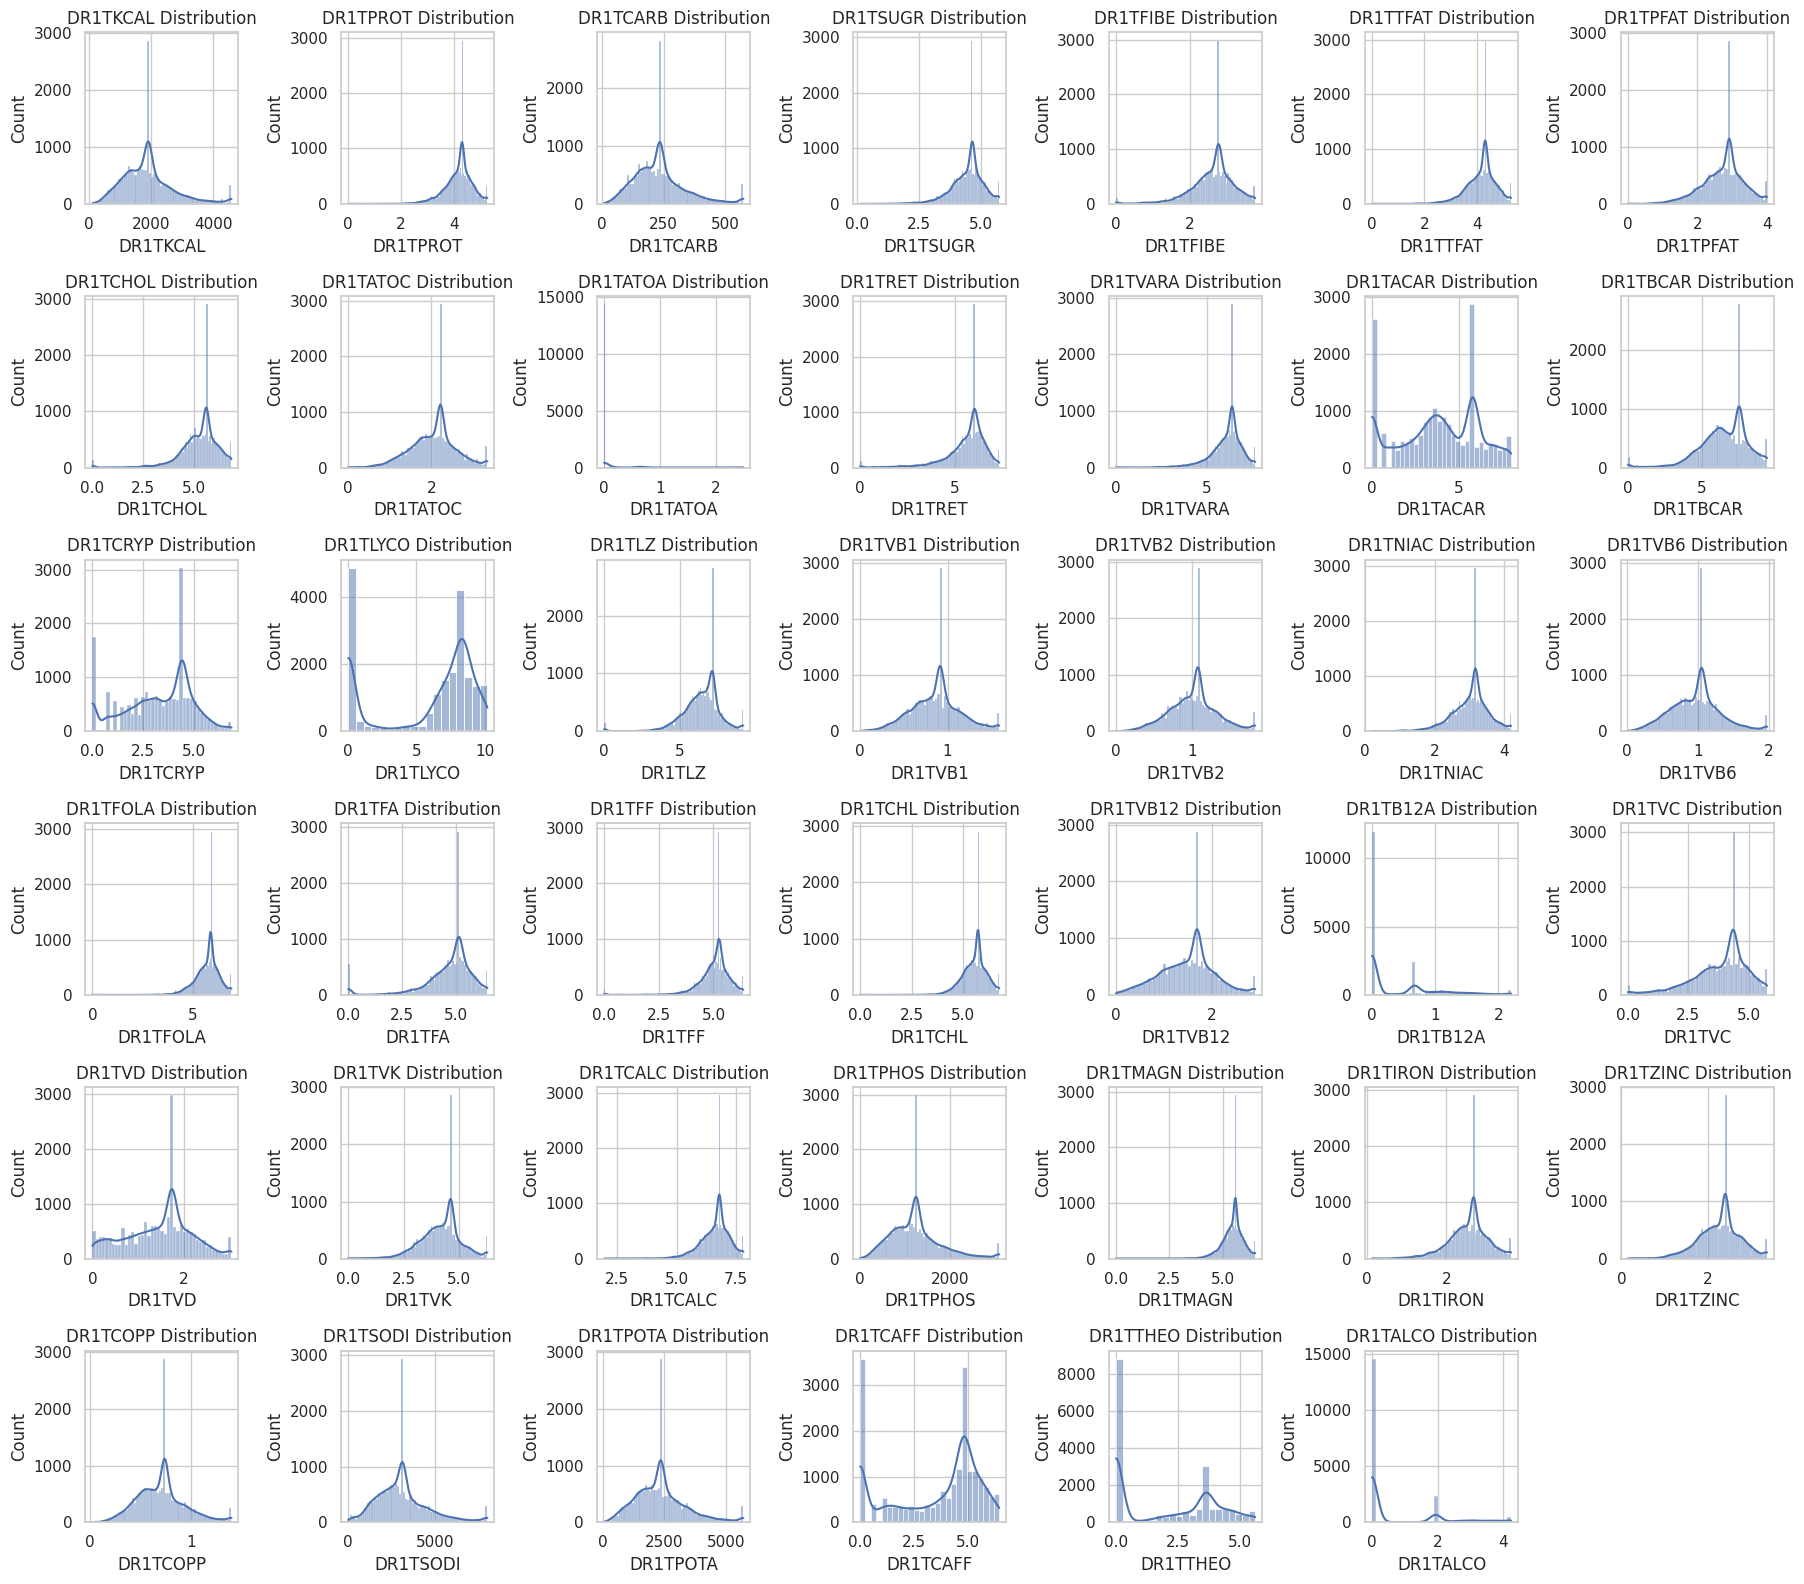

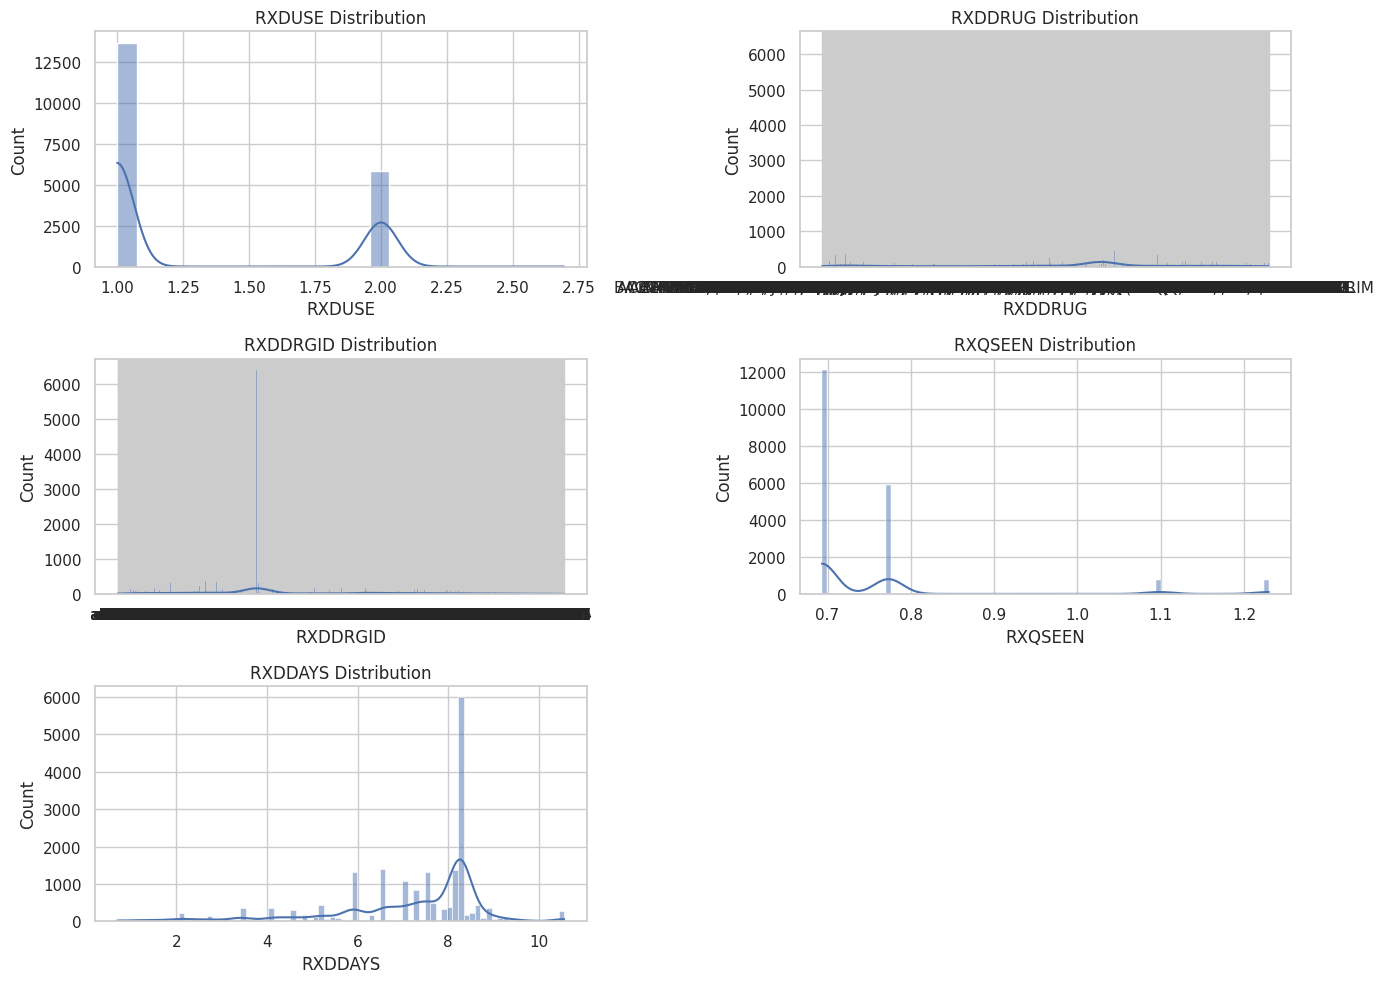

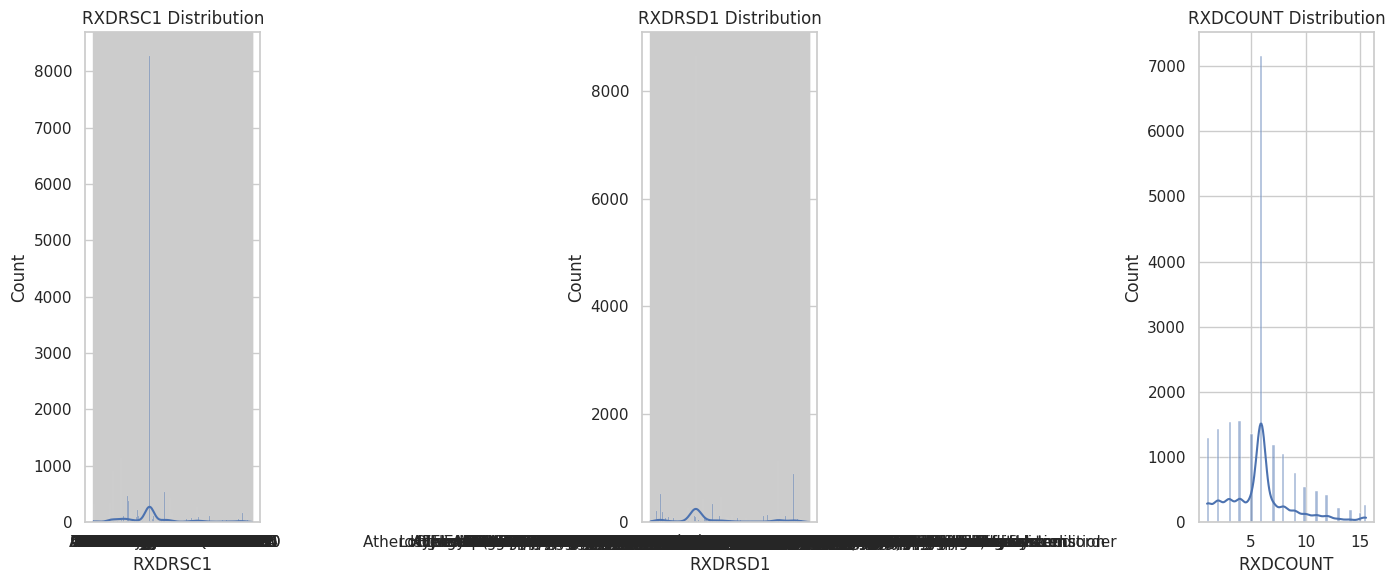

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Visualizing all columns by their groups

# 1. Diet-related visualizations
plt.figure(figsize=(18, 16))
for i, col in enumerate(diet_columns):  # Loop through all diet columns
    plt.subplot(6, 7, i + 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# 2. Medication-related visualizations
plt.figure(figsize=(14, 10))
for i, col in enumerate(medication_columns):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# 3. Healthcare-related visualizations
plt.figure(figsize=(14, 6))
for i, col in enumerate(healthcare_columns):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()


<ipython-input-31-ec9a032a484a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RIAGENDR', data=df_cleaned, palette='Set2')


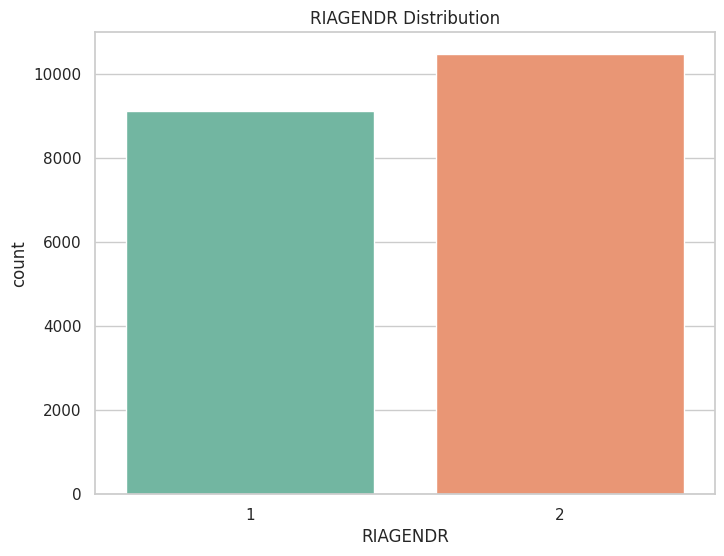

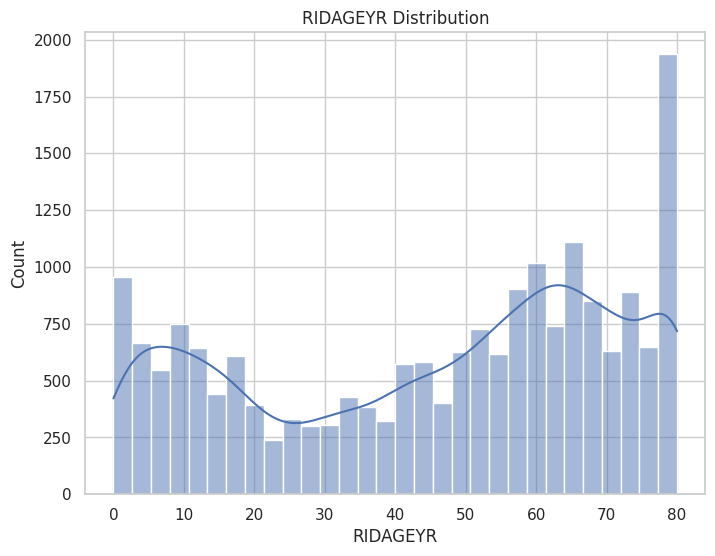

<ipython-input-31-ec9a032a484a>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RIDRETH1', data=df_cleaned, palette='Set2')


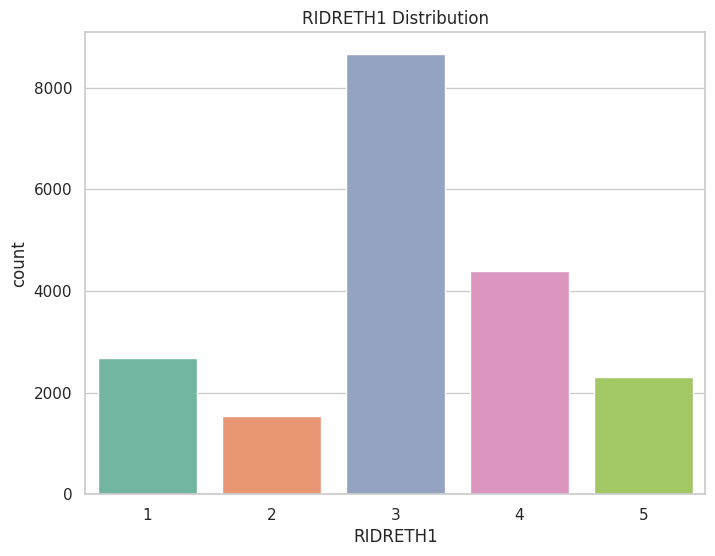

<ipython-input-31-ec9a032a484a>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RIDEXMON', data=df_cleaned, palette='Set2')


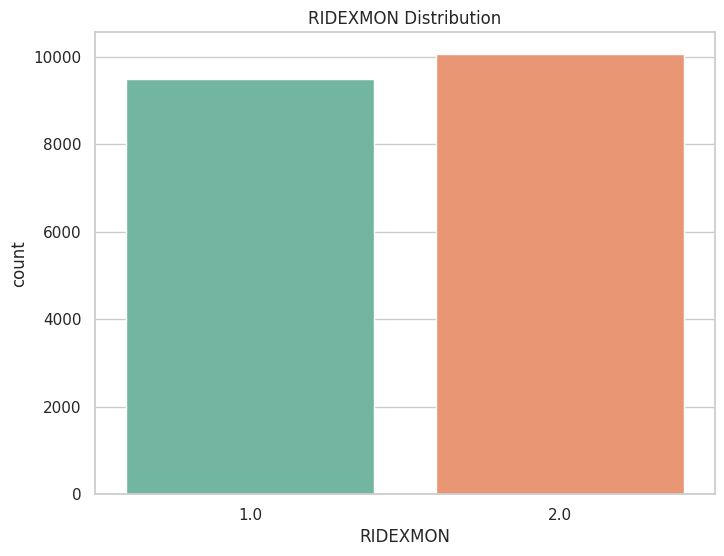

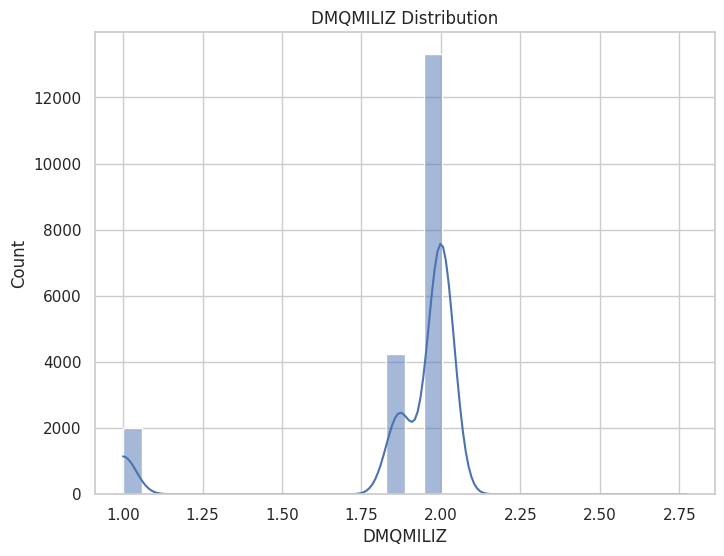

<ipython-input-31-ec9a032a484a>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DMDHHSIZ', data=df_cleaned, palette='Set2')


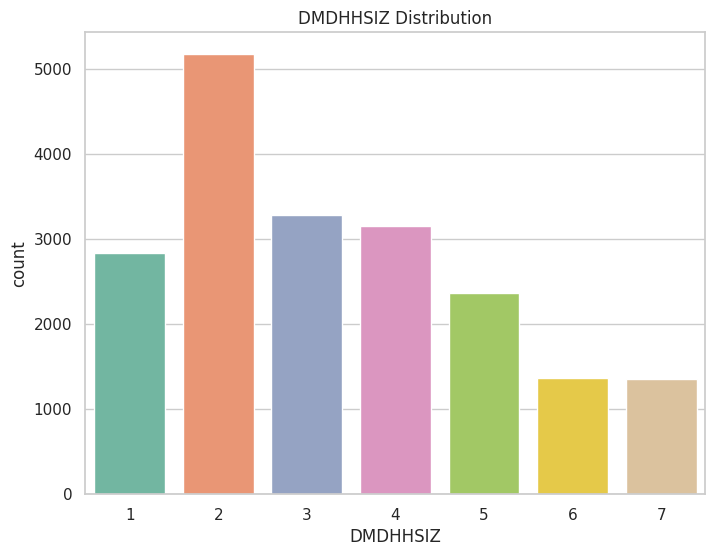

<ipython-input-31-ec9a032a484a>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DMDHRGND', data=df_cleaned, palette='Set2')


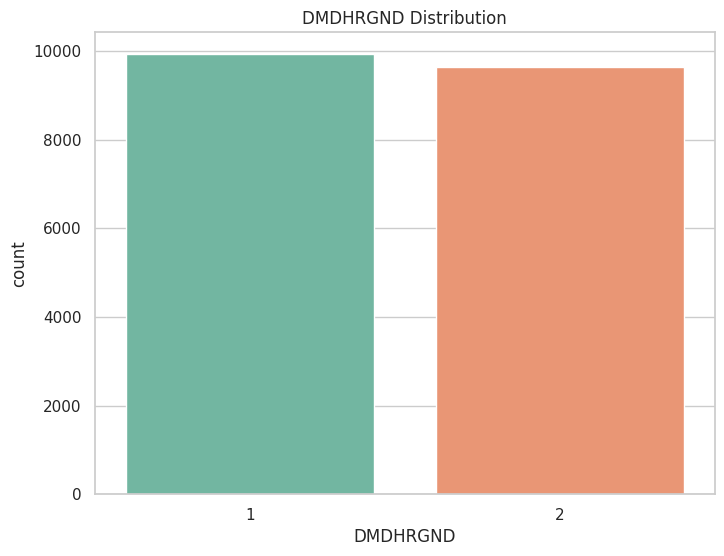

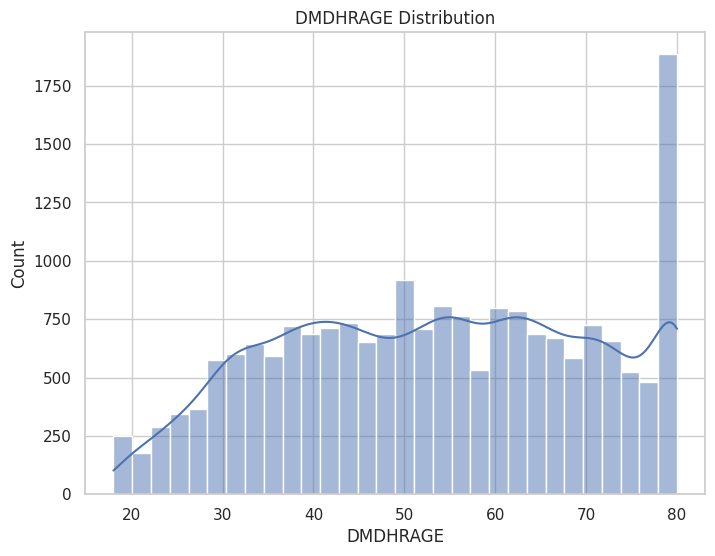

<ipython-input-31-ec9a032a484a>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SDMVPSU', data=df_cleaned, palette='Set2')


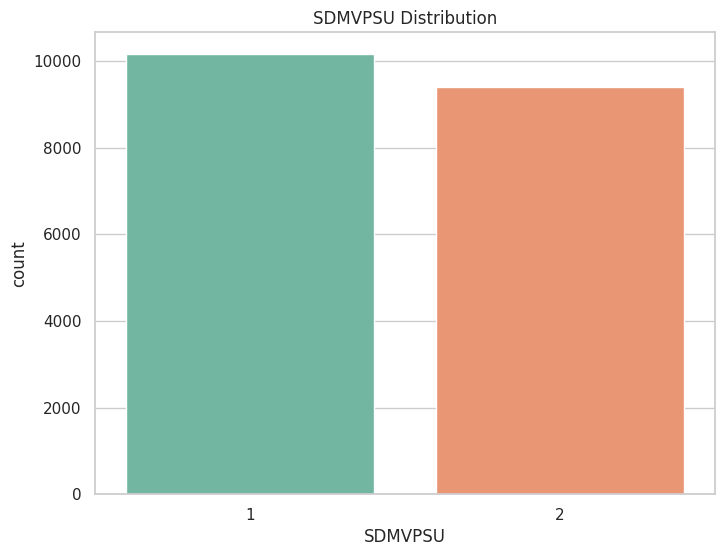

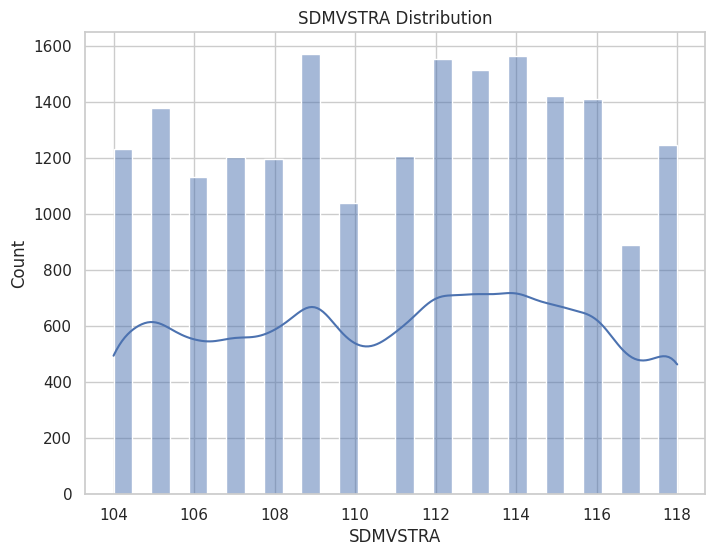

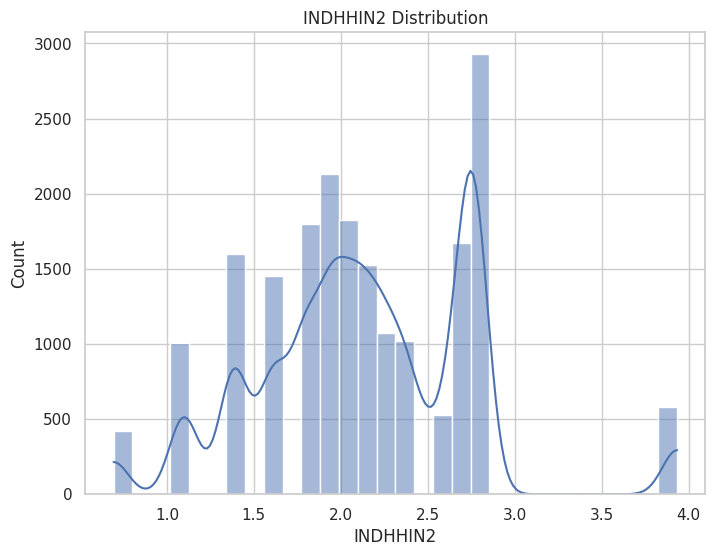

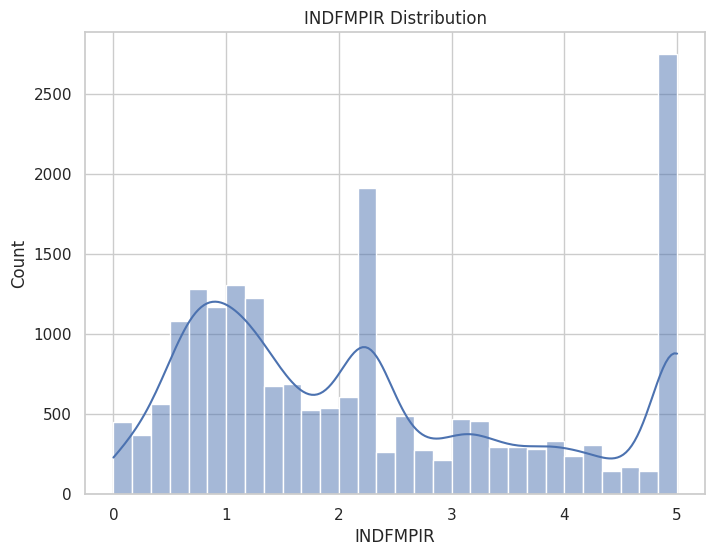

In [ ]:
# Re-plotting each demographic-related variable individually

# Plot for RIAGENDR
plt.figure(figsize=(8, 6))
sns.countplot(x='RIAGENDR', data=df_cleaned, palette='Set2')
plt.title('RIAGENDR Distribution')
plt.show()

# Plot for RIDAGEYR
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['RIDAGEYR'], kde=True, bins=30)
plt.title('RIDAGEYR Distribution')
plt.show()

# Plot for RIDRETH1
plt.figure(figsize=(8, 6))
sns.countplot(x='RIDRETH1', data=df_cleaned, palette='Set2')
plt.title('RIDRETH1 Distribution')
plt.show()

# Plot for RIDEXMON
plt.figure(figsize=(8, 6))
sns.countplot(x='RIDEXMON', data=df_cleaned, palette='Set2')
plt.title('RIDEXMON Distribution')
plt.show()

# Plot for DMQMILIZ
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['DMQMILIZ'], kde=True, bins=30)
plt.title('DMQMILIZ Distribution')
plt.show()

# Plot for DMDHHSIZ
plt.figure(figsize=(8, 6))
sns.countplot(x='DMDHHSIZ', data=df_cleaned, palette='Set2')
plt.title('DMDHHSIZ Distribution')
plt.show()

# Plot for DMDHRGND
plt.figure(figsize=(8, 6))
sns.countplot(x='DMDHRGND', data=df_cleaned, palette='Set2')
plt.title('DMDHRGND Distribution')
plt.show()

# Plot for DMDHRAGE
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['DMDHRAGE'], kde=True, bins=30)
plt.title('DMDHRAGE Distribution')
plt.show()


# Plot for SDMVPSU
plt.figure(figsize=(8, 6))
sns.countplot(x='SDMVPSU', data=df_cleaned, palette='Set2')
plt.title('SDMVPSU Distribution')
plt.show()

# Plot for SDMVSTRA
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['SDMVSTRA'], kde=True, bins=30)
plt.title('SDMVSTRA Distribution')
plt.show()

# Plot for INDHHIN2
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['INDHHIN2'], kde=True, bins=30)
plt.title('INDHHIN2 Distribution')
plt.show()

# Plot for INDFMPIR
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['INDFMPIR'], kde=True, bins=30)
plt.title('INDFMPIR Distribution')
plt.show()

<ipython-input-30-070cc9c1cde6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column_name, data=df, palette='Set2')


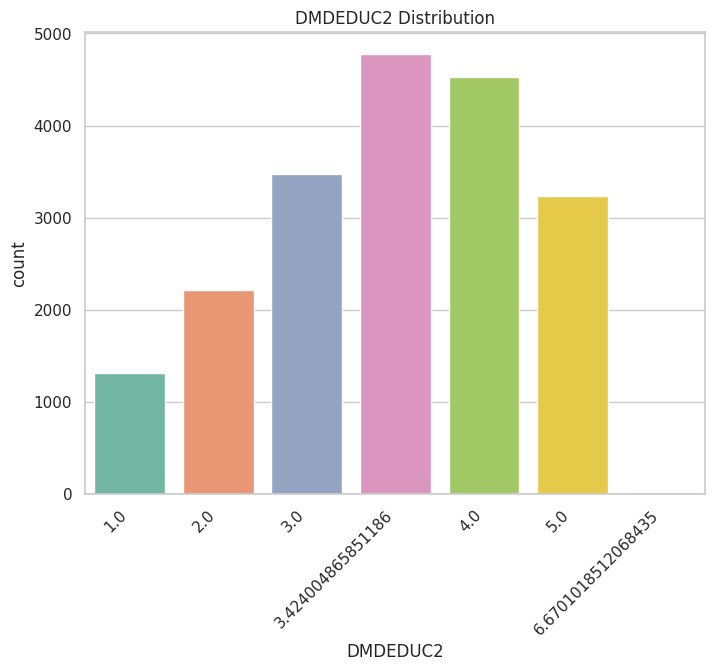

<ipython-input-30-070cc9c1cde6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column_name, data=df, palette='Set2')


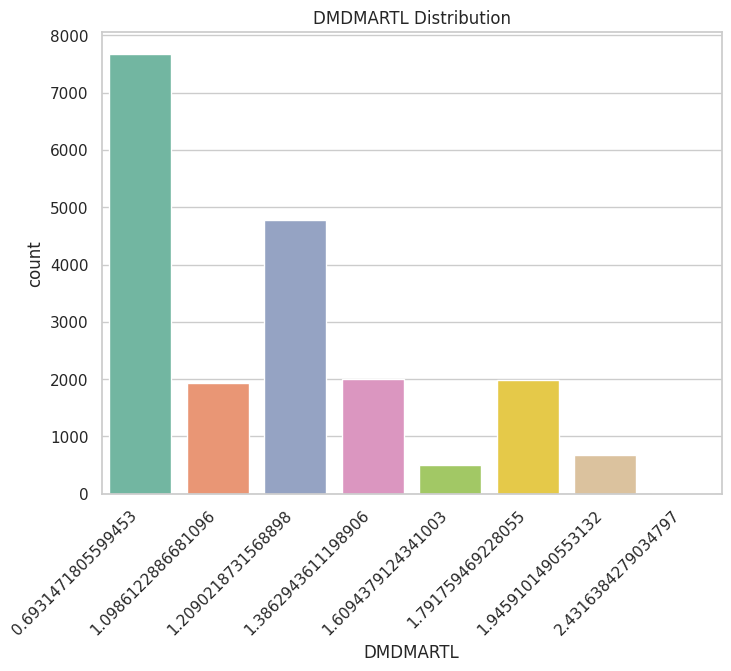

<ipython-input-30-070cc9c1cde6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column_name, data=df, palette='Set2')


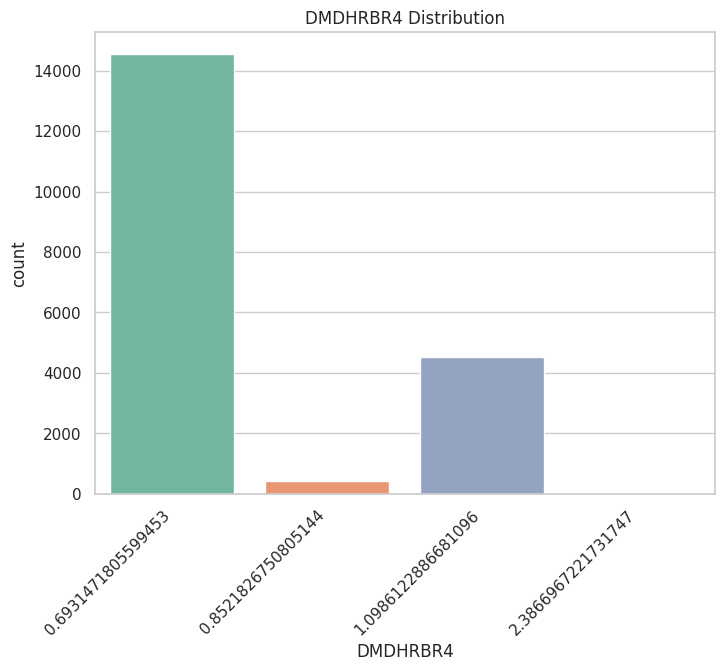

<ipython-input-30-070cc9c1cde6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column_name, data=df, palette='Set2')


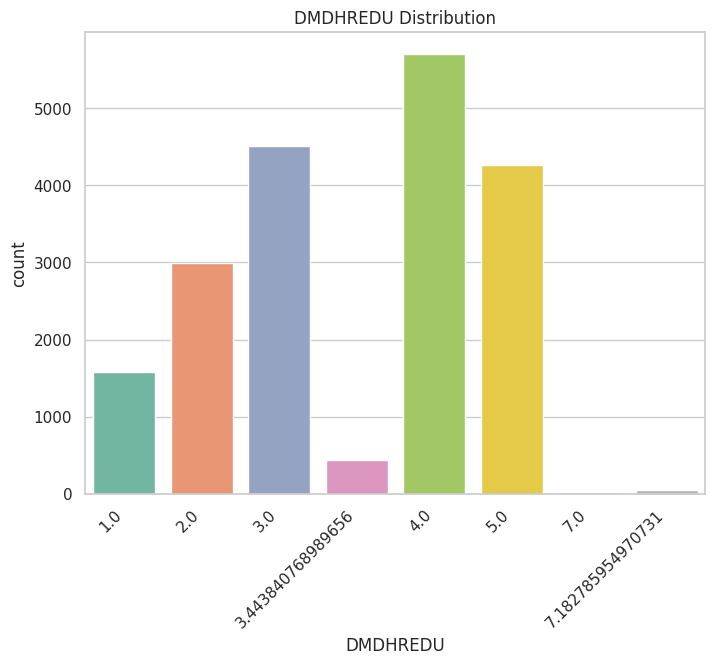

<ipython-input-30-070cc9c1cde6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column_name, data=df, palette='Set2')


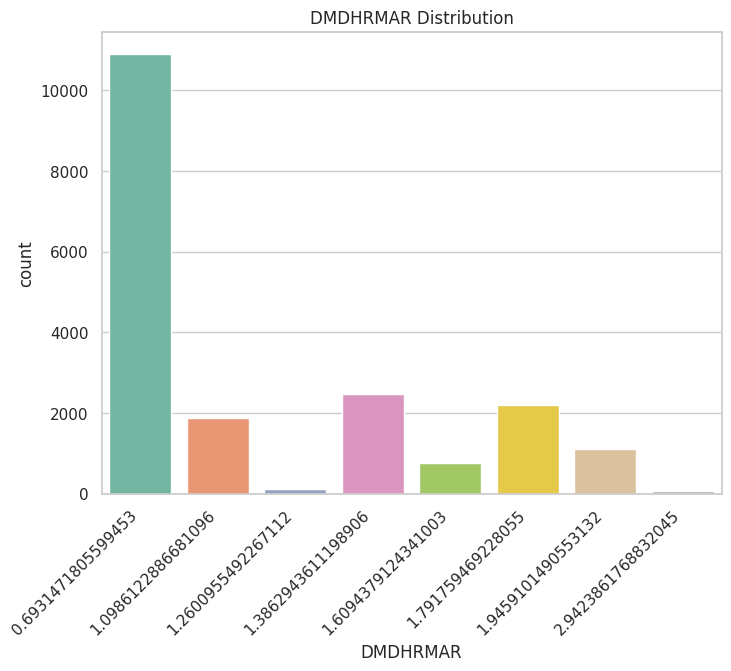

<ipython-input-30-070cc9c1cde6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column_name, data=df, palette='Set2')


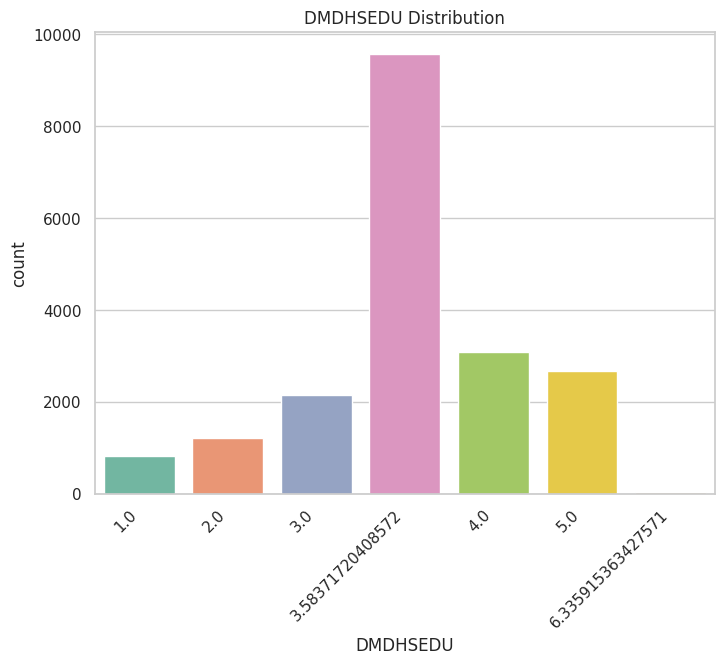

In [ ]:
# Fixing the x-axis labels by rotating them and adjusting the figure size

# Function to create count plots with rotated x-axis labels
def create_countplot_with_rotation(column_name, df):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column_name, data=df, palette='Set2')
    plt.title(f'{column_name} Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Apply this function to the problematic columns
columns_with_jumbled_xaxis = ['DMDEDUC2', 'DMDMARTL', 'DMDHRBR4', 'DMDHREDU', 'DMDHRMAR', 'DMDHSEDU']

for col in columns_with_jumbled_xaxis:
    create_countplot_with_rotation(col, df_cleaned)

## Bivariate Analysis

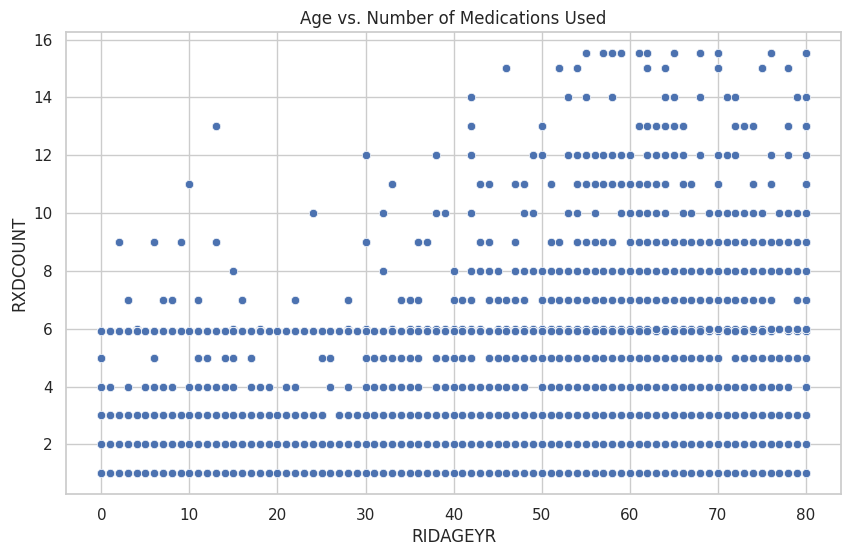

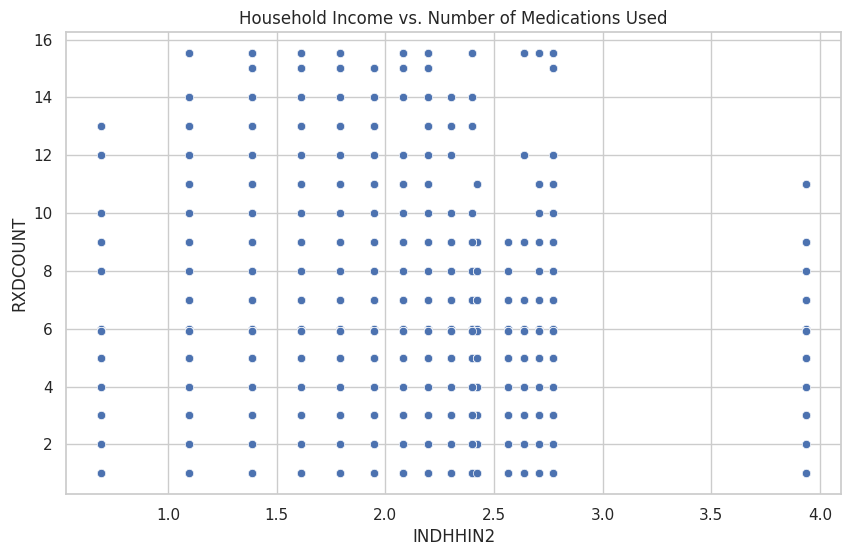

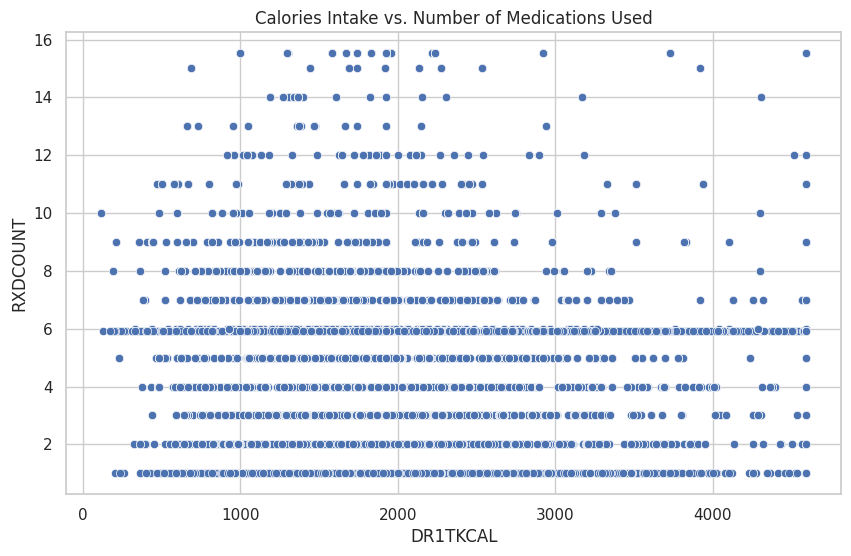

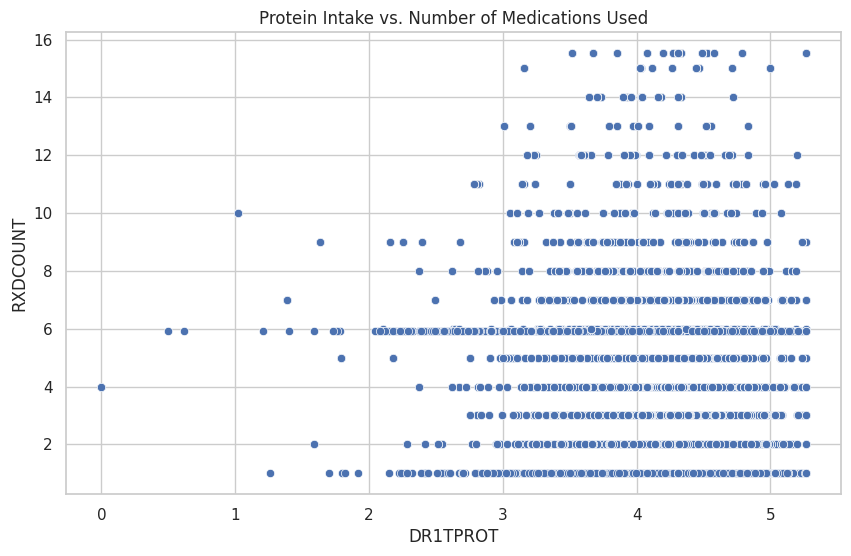

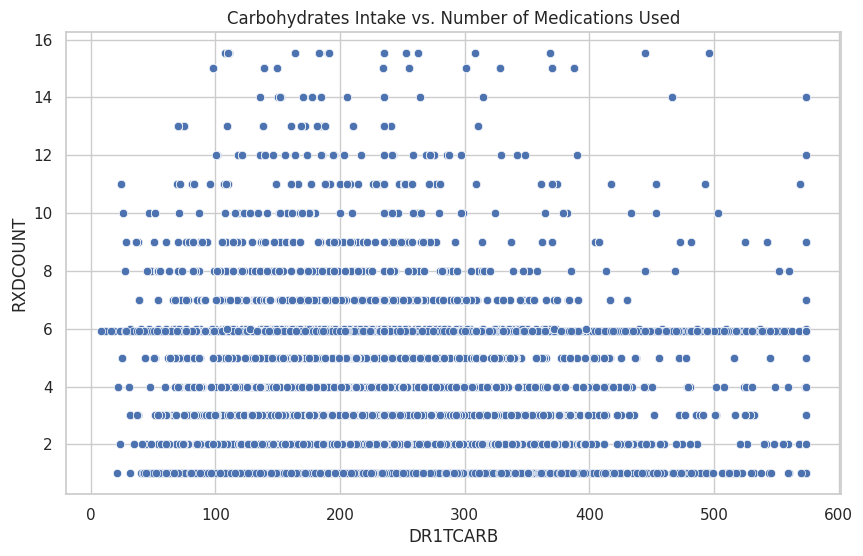

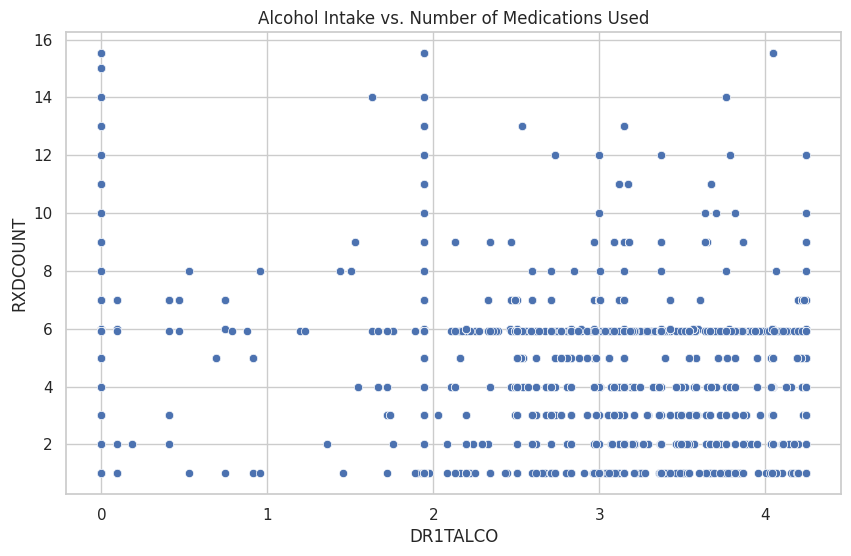

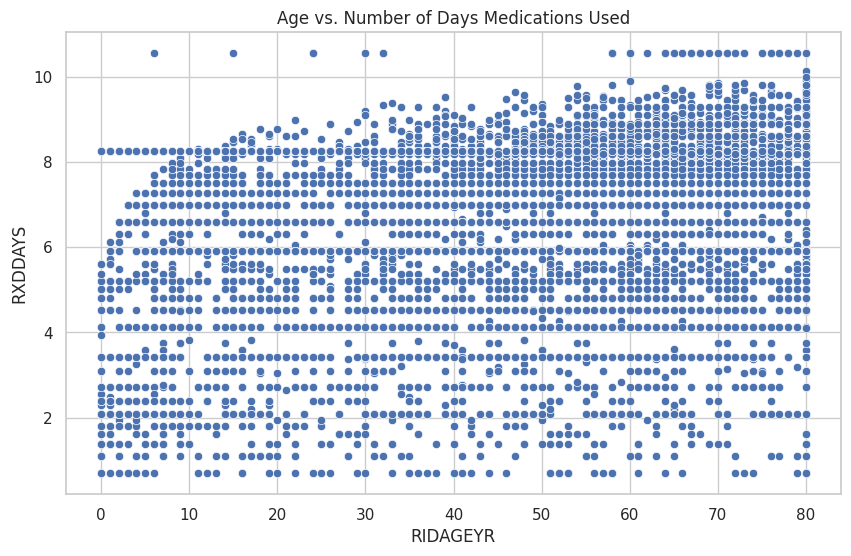

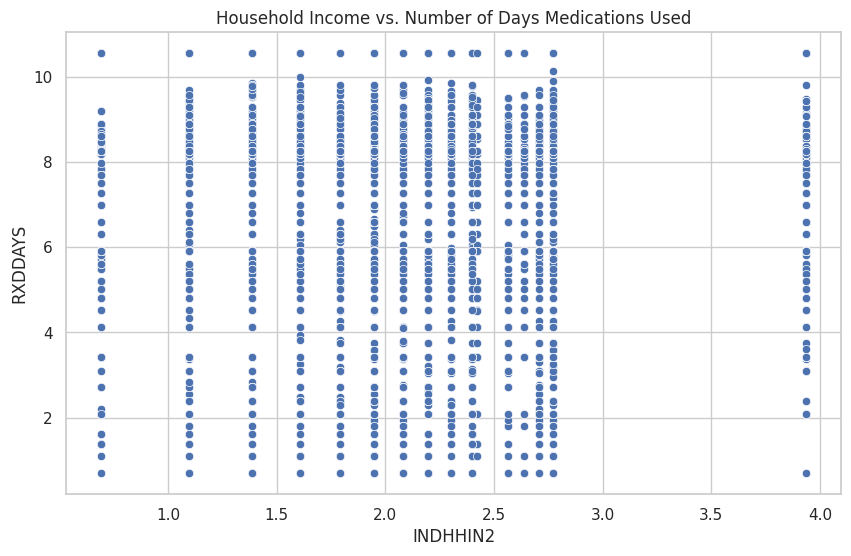

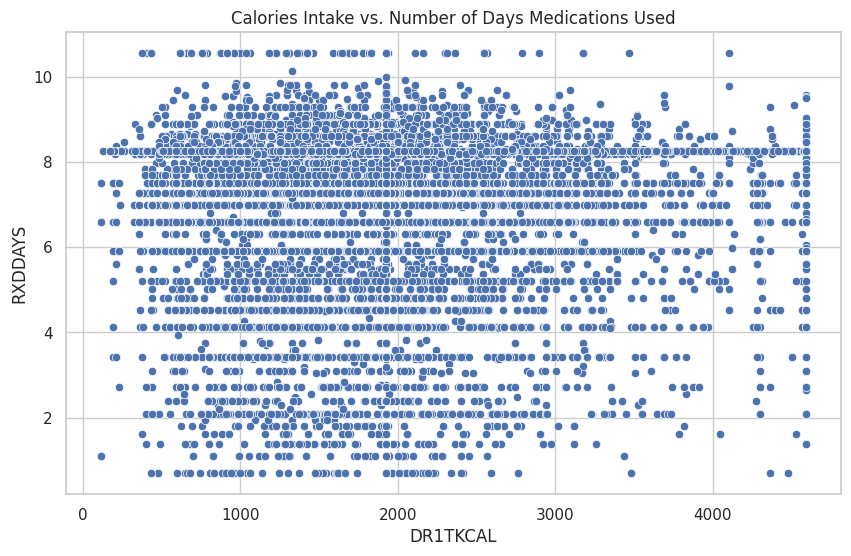

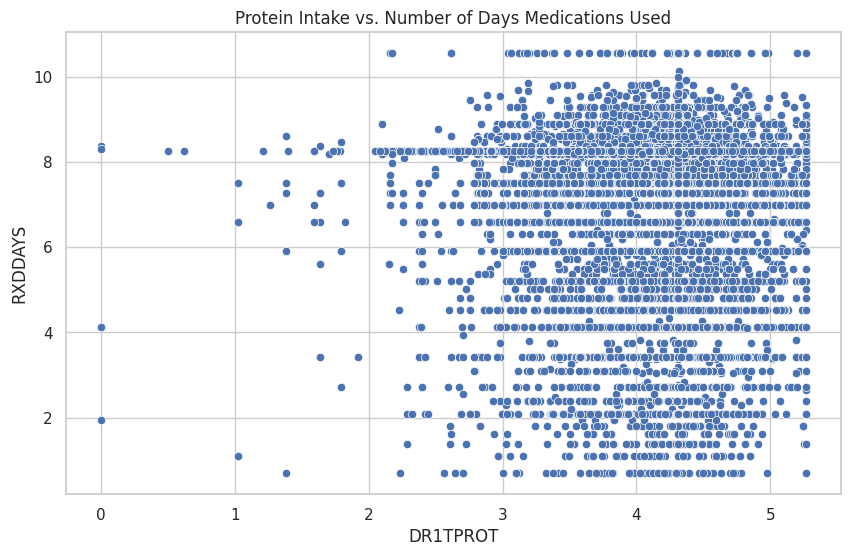

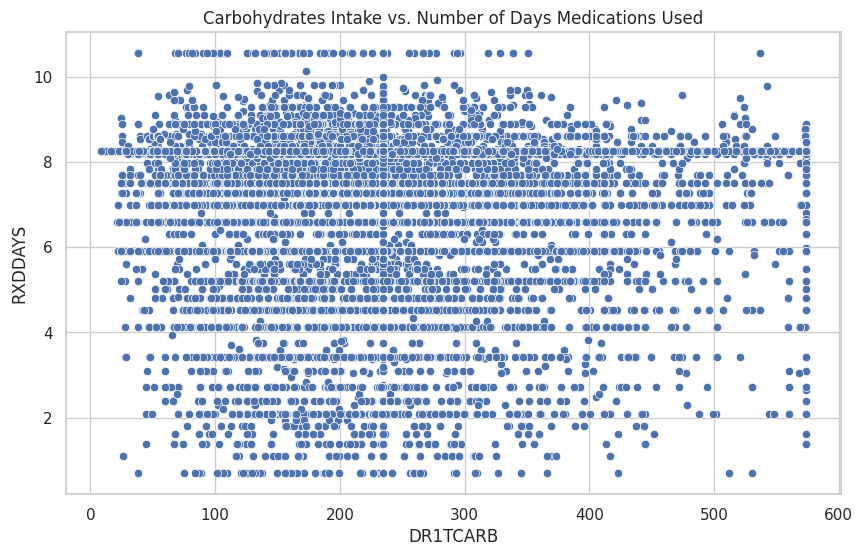

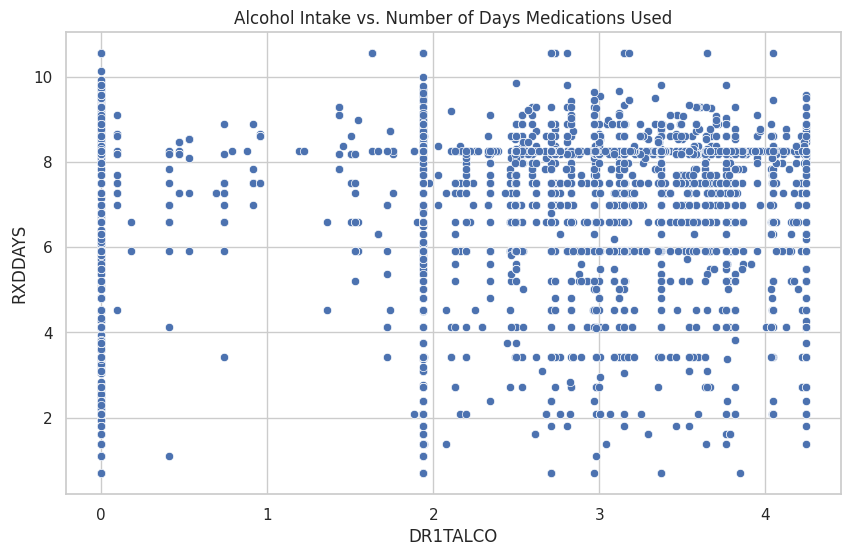

In [ ]:
# Scatter Plots

# Scatter plot: Age vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RIDAGEYR', y='RXDCOUNT', data=df_cleaned)
plt.title('Age vs. Number of Medications Used')
plt.show()

# Scatter plot: Household Income vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='INDHHIN2', y='RXDCOUNT', data=df_cleaned)
plt.title('Household Income vs. Number of Medications Used')
plt.show()

# Scatter plot: Calories Intake vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DR1TKCAL', y='RXDCOUNT', data=df_cleaned)
plt.title('Calories Intake vs. Number of Medications Used')
plt.show()

# Scatter plot: Protein Intake vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DR1TPROT', y='RXDCOUNT', data=df_cleaned)
plt.title('Protein Intake vs. Number of Medications Used')
plt.show()

# Scatter plot: Carbohydrates Intake vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DR1TCARB', y='RXDCOUNT', data=df_cleaned)
plt.title('Carbohydrates Intake vs. Number of Medications Used')
plt.show()

# Scatter plot: Alcohol Intake vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DR1TALCO', y='RXDCOUNT', data=df_cleaned)
plt.title('Alcohol Intake vs. Number of Medications Used')
plt.show()

# Scatter plot: Age vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RIDAGEYR', y='RXDDAYS', data=df_cleaned)
plt.title('Age vs. Number of Days Medications Used')
plt.show()

# Scatter plot: Household Income vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='INDHHIN2', y='RXDDAYS', data=df_cleaned)
plt.title('Household Income vs. Number of Days Medications Used')
plt.show()

# Scatter plot: Calories Intake vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DR1TKCAL', y='RXDDAYS', data=df_cleaned)
plt.title('Calories Intake vs. Number of Days Medications Used')
plt.show()

# Scatter plot: Protein Intake vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DR1TPROT', y='RXDDAYS', data=df_cleaned)
plt.title('Protein Intake vs. Number of Days Medications Used')
plt.show()

# Scatter plot: Carbohydrates Intake vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DR1TCARB', y='RXDDAYS', data=df_cleaned)
plt.title('Carbohydrates Intake vs. Number of Days Medications Used')
plt.show()

# Scatter plot: Alcohol Intake vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DR1TALCO', y='RXDDAYS', data=df_cleaned)
plt.title('Alcohol Intake vs. Number of Days Medications Used')
plt.show()


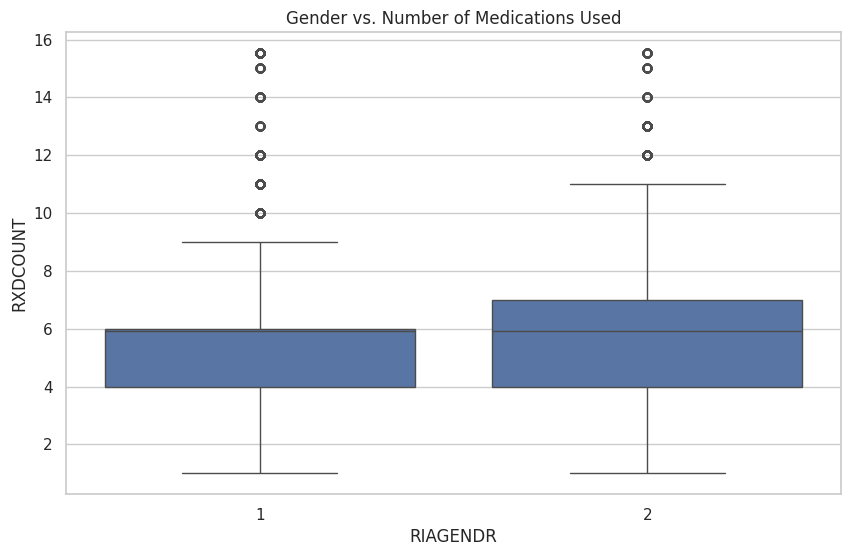

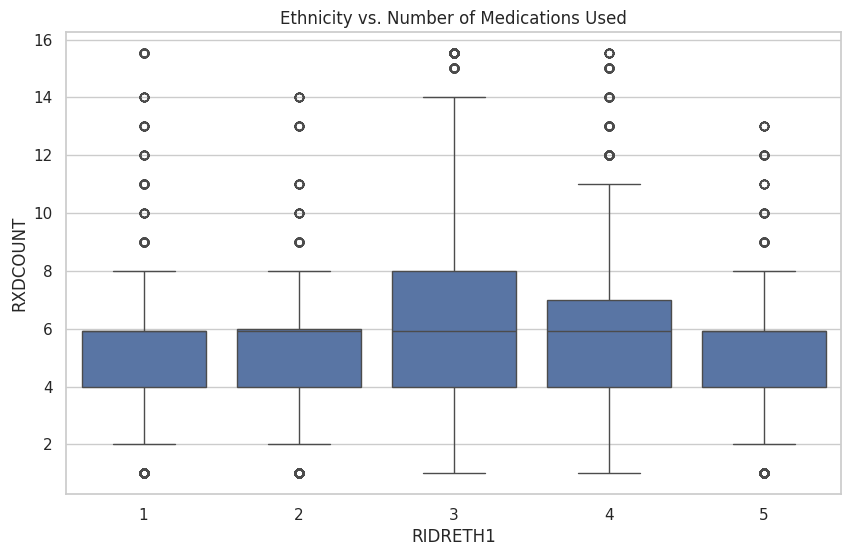

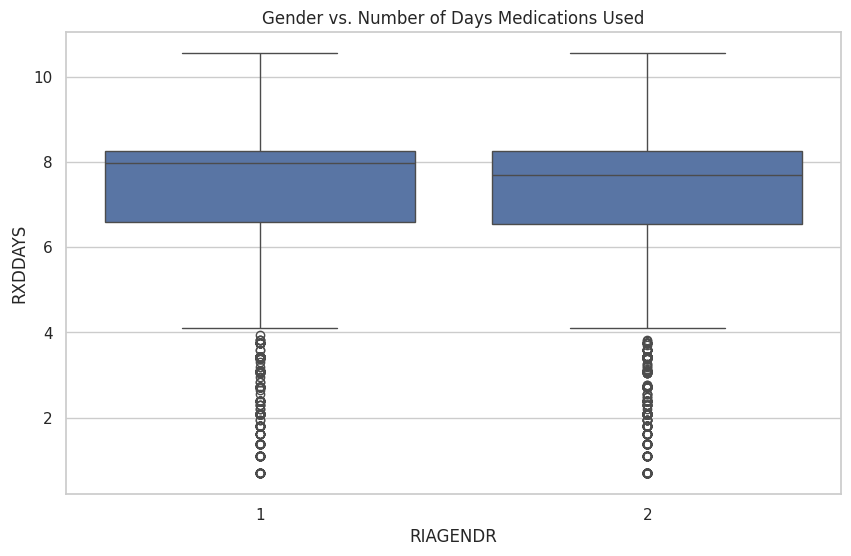

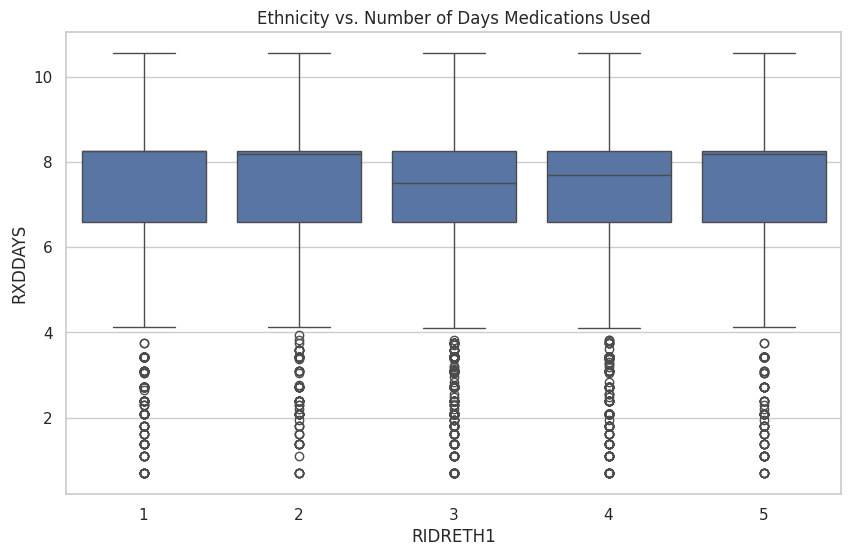

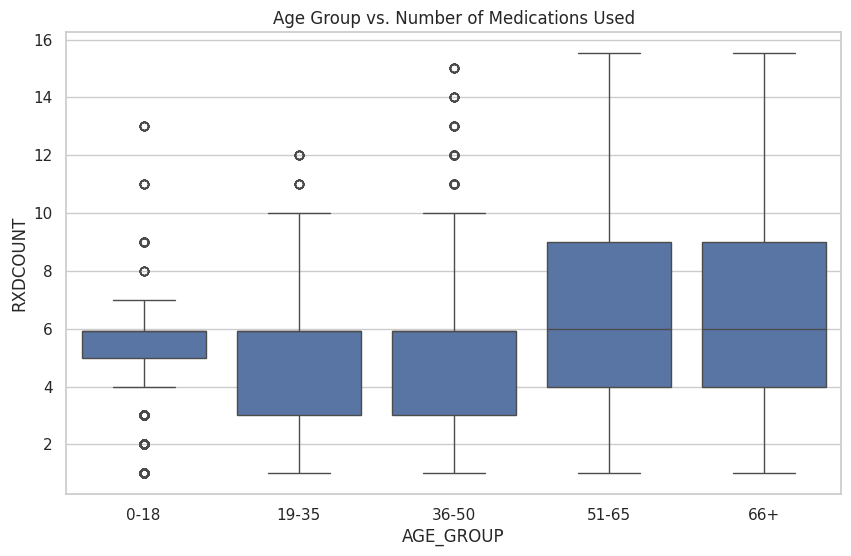

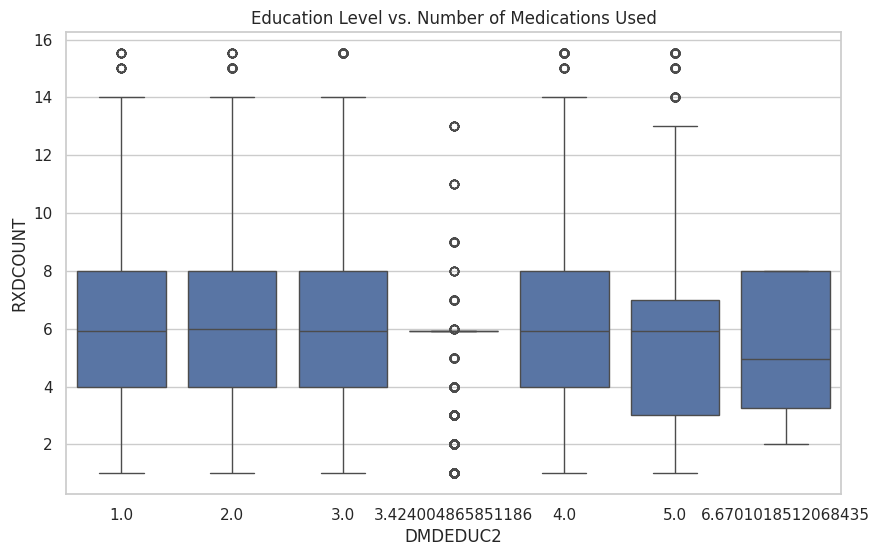

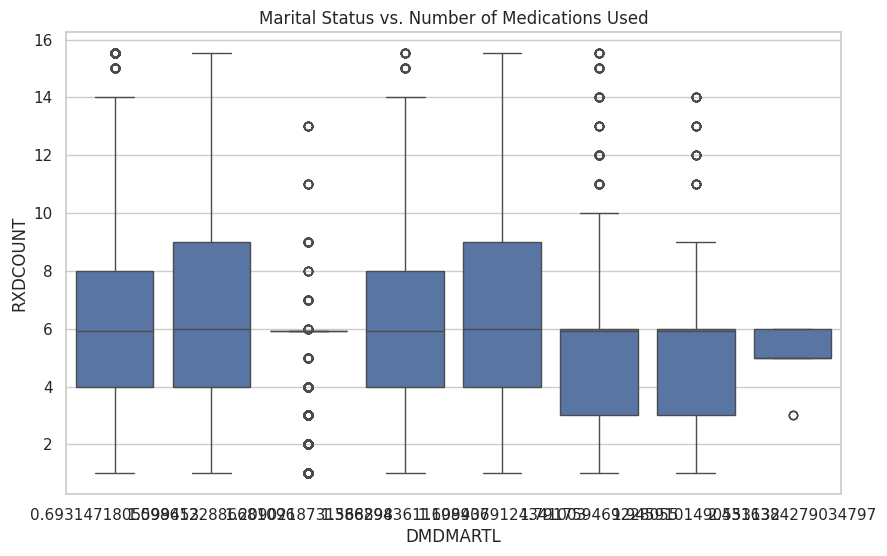

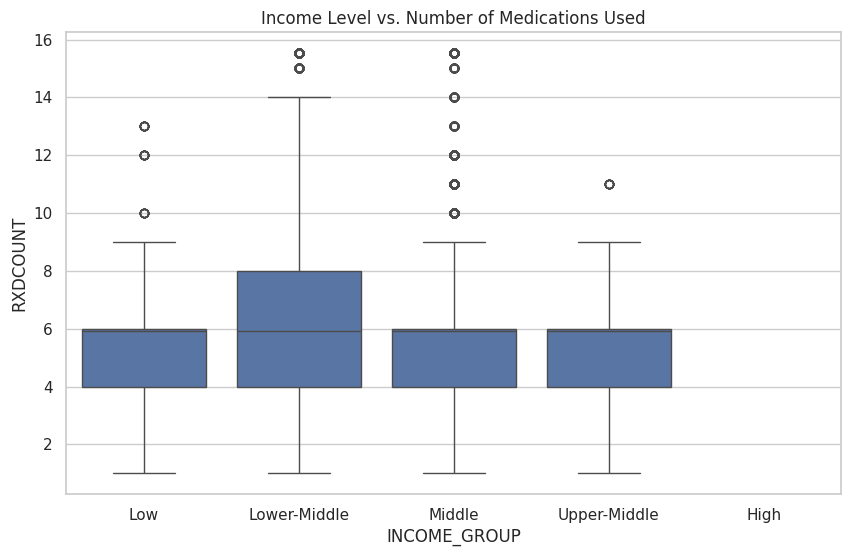

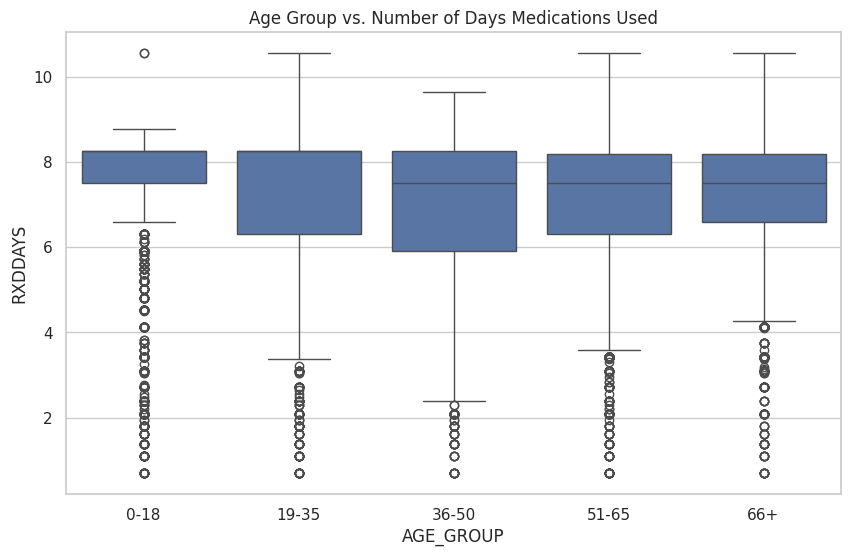

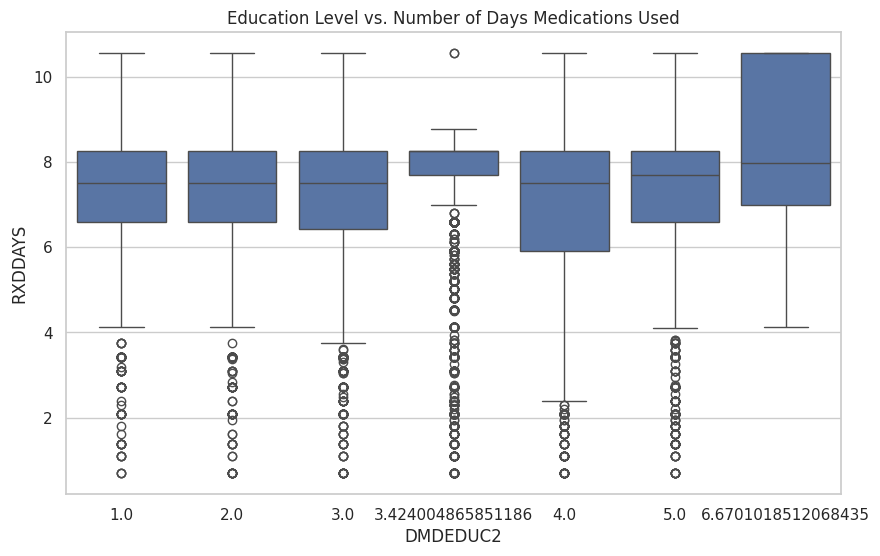

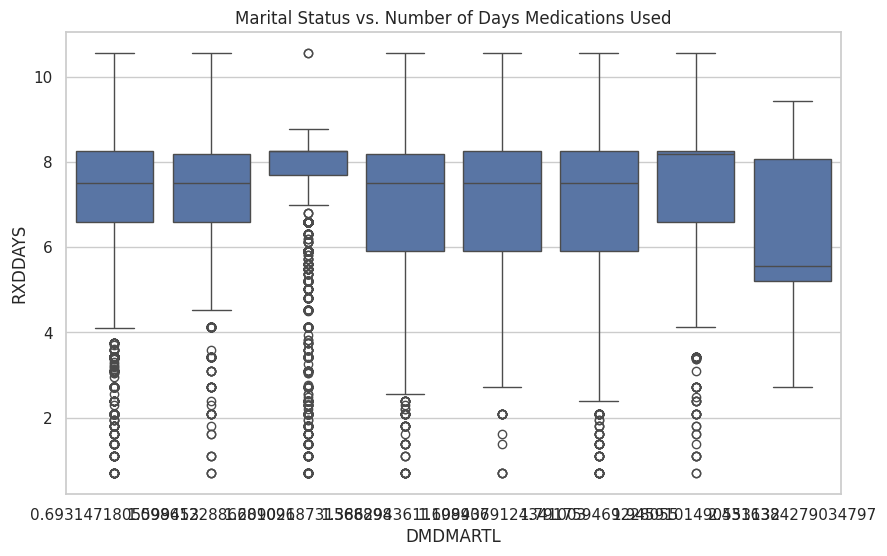

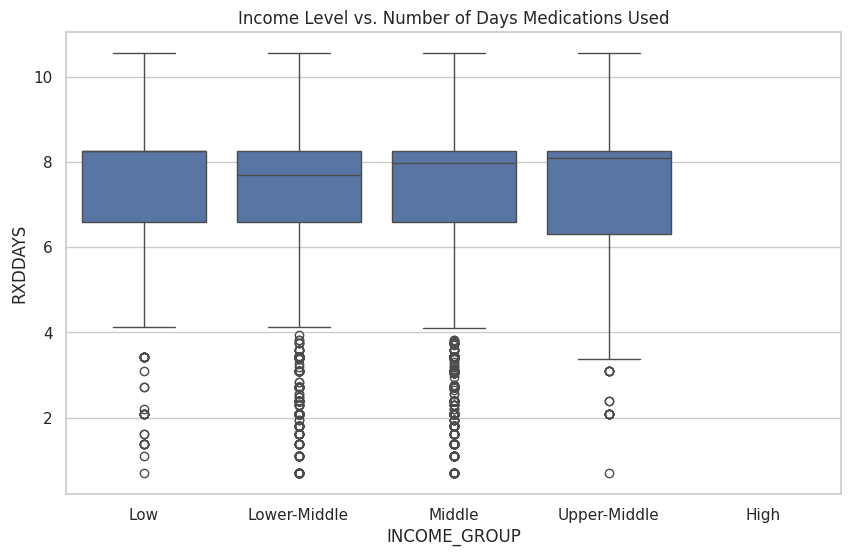

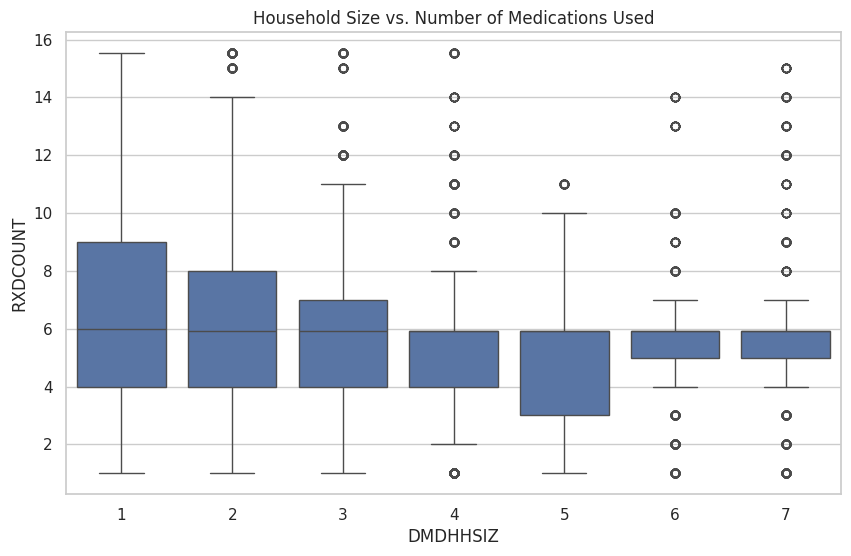

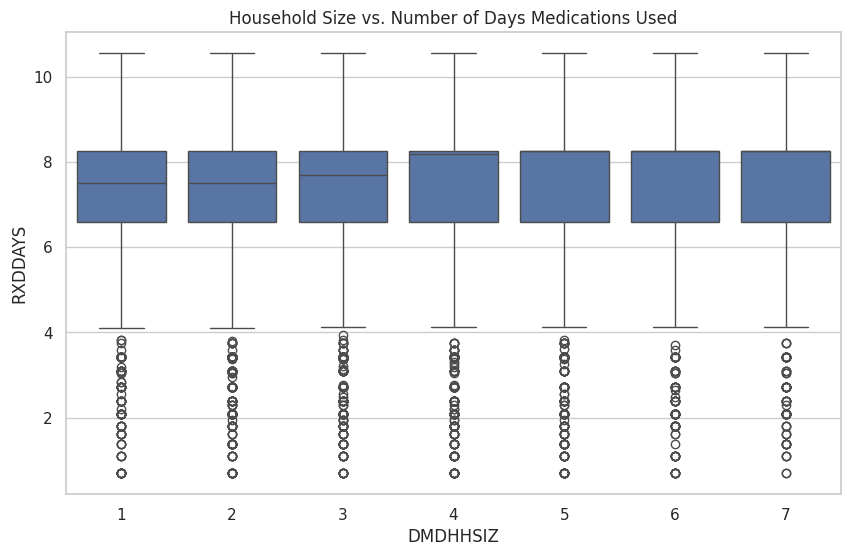

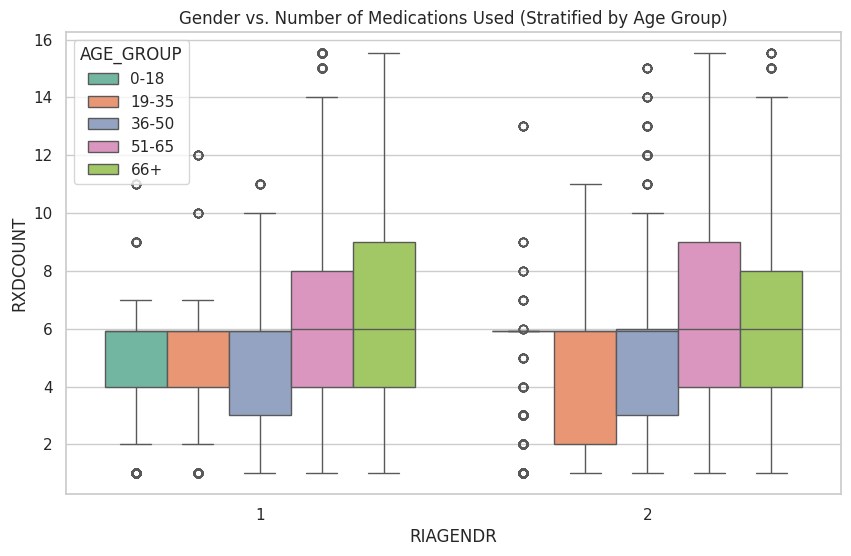

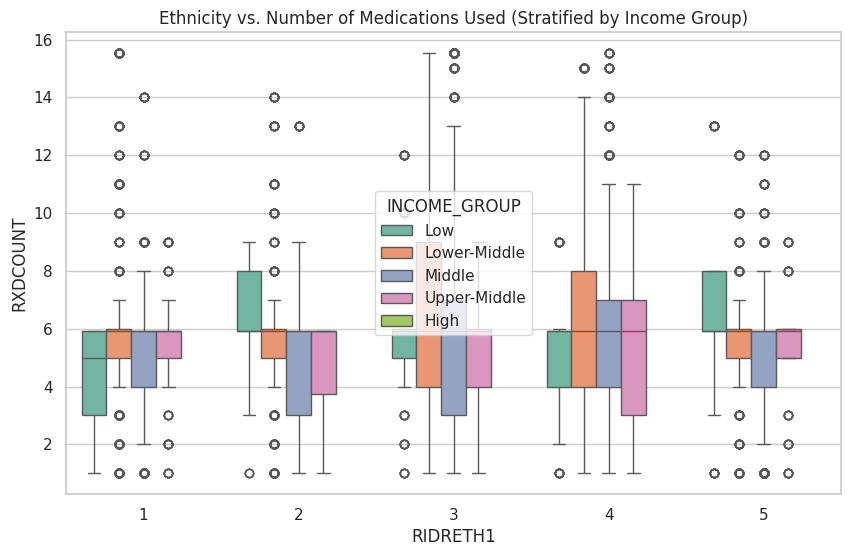

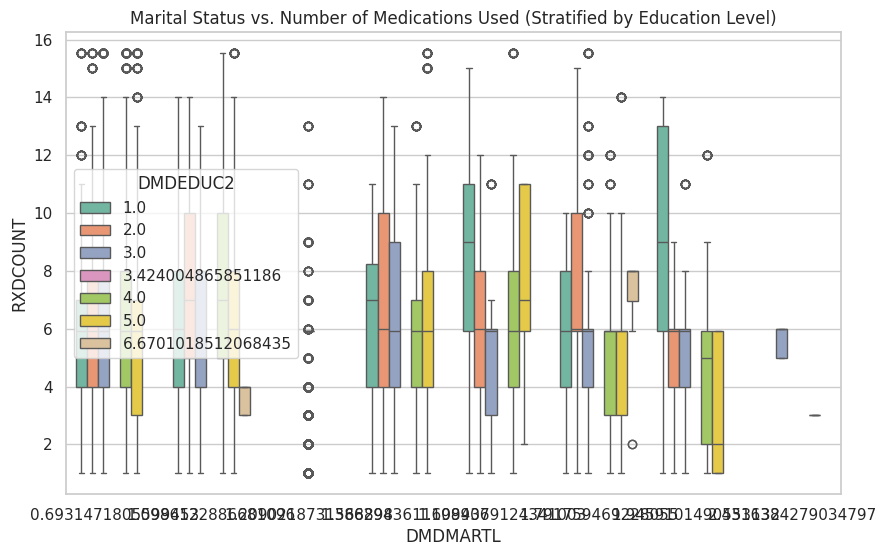

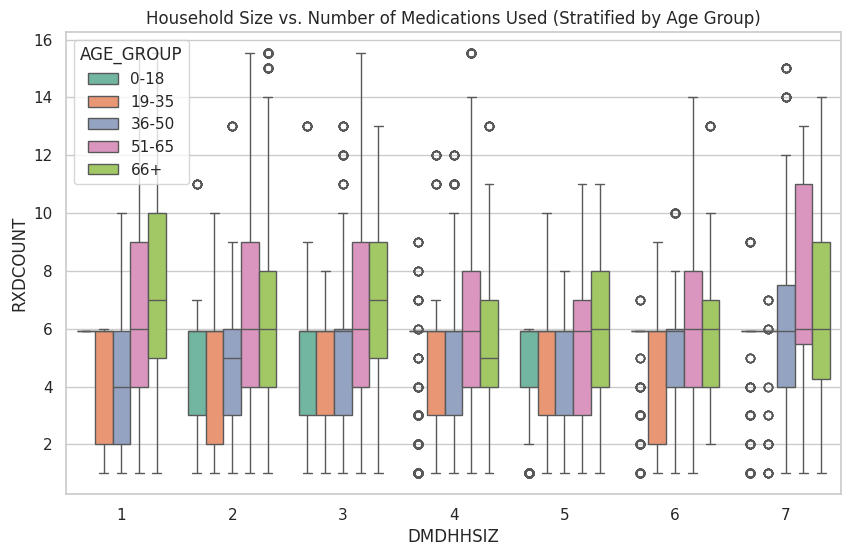

In [ ]:
# Updated Box Plots with corrected use of palette and hue

# Box plot: Gender vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='RIAGENDR', y='RXDCOUNT', data=df_cleaned, hue=None)
plt.title('Gender vs. Number of Medications Used')
plt.show()

# Box plot: Ethnicity vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='RIDRETH1', y='RXDCOUNT', data=df_cleaned, hue=None)
plt.title('Ethnicity vs. Number of Medications Used')
plt.show()

# Box plot: Gender vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='RIAGENDR', y='RXDDAYS', data=df_cleaned, hue=None)
plt.title('Gender vs. Number of Days Medications Used')
plt.show()

# Box plot: Ethnicity vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='RIDRETH1', y='RXDDAYS', data=df_cleaned, hue=None)
plt.title('Ethnicity vs. Number of Days Medications Used')
plt.show()

# Box plot: Age Group vs. Number of Medications Used
plt.figure(figsize=(10, 6))
df_cleaned['AGE_GROUP'] = pd.cut(df_cleaned['RIDAGEYR'], bins=[0, 18, 35, 50, 65, 100], labels=['0-18', '19-35', '36-50', '51-65', '66+'])
sns.boxplot(x='AGE_GROUP', y='RXDCOUNT', data=df_cleaned, hue=None)
plt.title('Age Group vs. Number of Medications Used')
plt.show()

# Box plot: Education Level vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='DMDEDUC2', y='RXDCOUNT', data=df_cleaned, hue=None)
plt.title('Education Level vs. Number of Medications Used')
plt.show()

# Box plot: Marital Status vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='DMDMARTL', y='RXDCOUNT', data=df_cleaned, hue=None)
plt.title('Marital Status vs. Number of Medications Used')
plt.show()

# Box plot: Income Level vs. Number of Medications Used
plt.figure(figsize=(10, 6))
df_cleaned['INCOME_GROUP'] = pd.cut(df_cleaned['INDHHIN2'], bins=[0, 1, 2, 3, 4, 5], labels=['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High'])
sns.boxplot(x='INCOME_GROUP', y='RXDCOUNT', data=df_cleaned, hue=None)
plt.title('Income Level vs. Number of Medications Used')
plt.show()

# Box plot: Age Group vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='AGE_GROUP', y='RXDDAYS', data=df_cleaned, hue=None)
plt.title('Age Group vs. Number of Days Medications Used')
plt.show()

# Box plot: Education Level vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='DMDEDUC2', y='RXDDAYS', data=df_cleaned, hue=None)
plt.title('Education Level vs. Number of Days Medications Used')
plt.show()

# Box plot: Marital Status vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='DMDMARTL', y='RXDDAYS', data=df_cleaned, hue=None)
plt.title('Marital Status vs. Number of Days Medications Used')
plt.show()

# Box plot: Income Level vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='INCOME_GROUP', y='RXDDAYS', data=df_cleaned, hue=None)
plt.title('Income Level vs. Number of Days Medications Used')
plt.show()

# Adding more relevant columns for the box plots

# Box plot: Household Size vs. Number of Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='DMDHHSIZ', y='RXDCOUNT', data=df_cleaned, hue=None)
plt.title('Household Size vs. Number of Medications Used')
plt.show()

# Box plot: Household Size vs. Number of Days Medications Used
plt.figure(figsize=(10, 6))
sns.boxplot(x='DMDHHSIZ', y='RXDDAYS', data=df_cleaned, hue=None)
plt.title('Household Size vs. Number of Days Medications Used')
plt.show()

# Box plot: Gender vs. Number of Medications Used (stratified by Age Group)
plt.figure(figsize=(10, 6))
sns.boxplot(x='RIAGENDR', y='RXDCOUNT', hue='AGE_GROUP', data=df_cleaned, palette='Set2')
plt.title('Gender vs. Number of Medications Used (Stratified by Age Group)')
plt.show()

# Box plot: Ethnicity vs. Number of Medications Used (stratified by Income Group)
plt.figure(figsize=(10, 6))
sns.boxplot(x='RIDRETH1', y='RXDCOUNT', hue='INCOME_GROUP', data=df_cleaned, palette='Set2')
plt.title('Ethnicity vs. Number of Medications Used (Stratified by Income Group)')
plt.show()

# Box plot: Marital Status vs. Number of Medications Used (stratified by Education Level)
plt.figure(figsize=(10, 6))
sns.boxplot(x='DMDMARTL', y='RXDCOUNT', hue='DMDEDUC2', data=df_cleaned, palette='Set2')
plt.title('Marital Status vs. Number of Medications Used (Stratified by Education Level)')
plt.show()

# Box plot: Household Size vs. Number of Medications Used (stratified by Age Group)
plt.figure(figsize=(10, 6))
sns.boxplot(x='DMDHHSIZ', y='RXDCOUNT', hue='AGE_GROUP', data=df_cleaned, palette='Set2')
plt.title('Household Size vs. Number of Medications Used (Stratified by Age Group)')
plt.show()


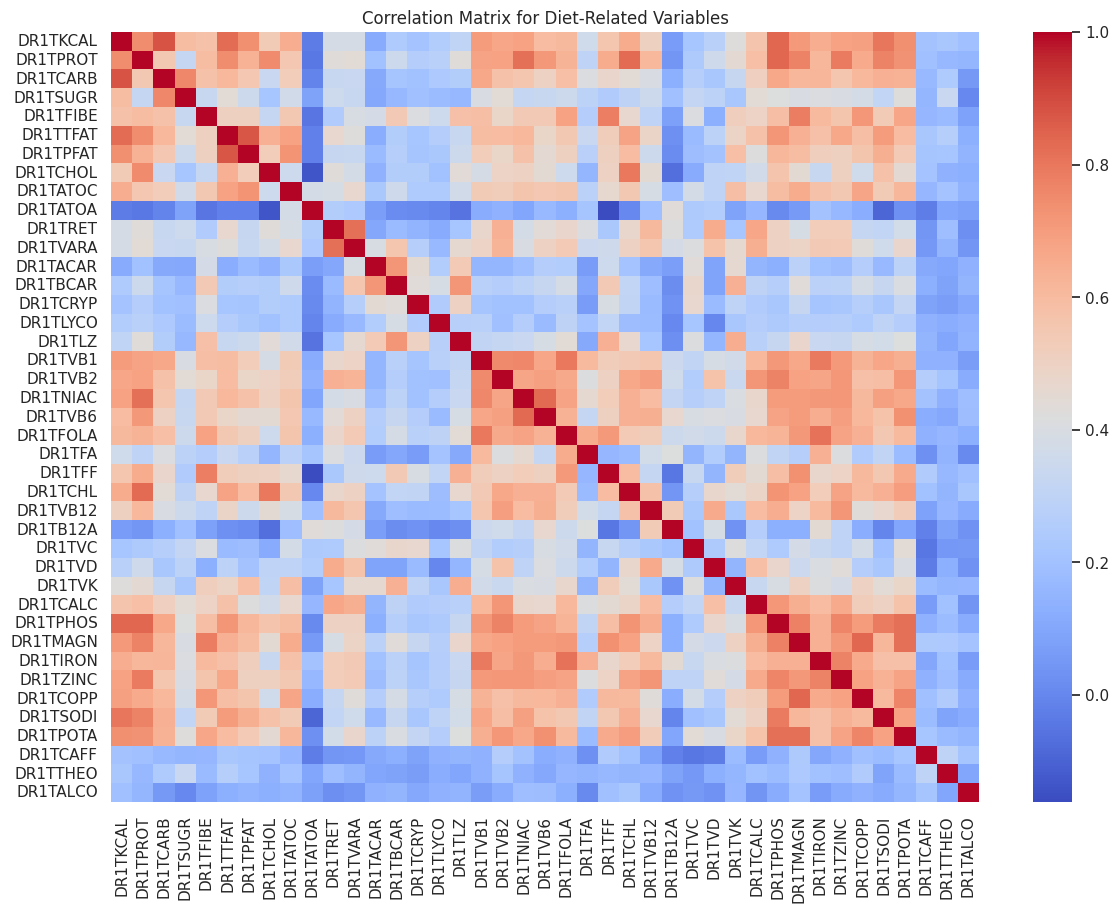

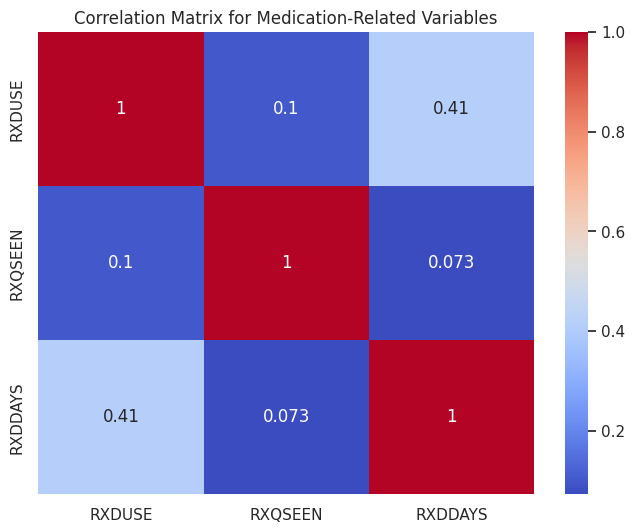

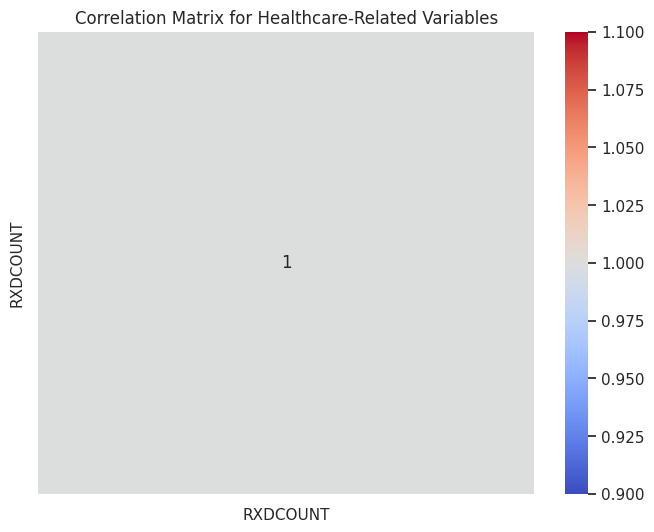

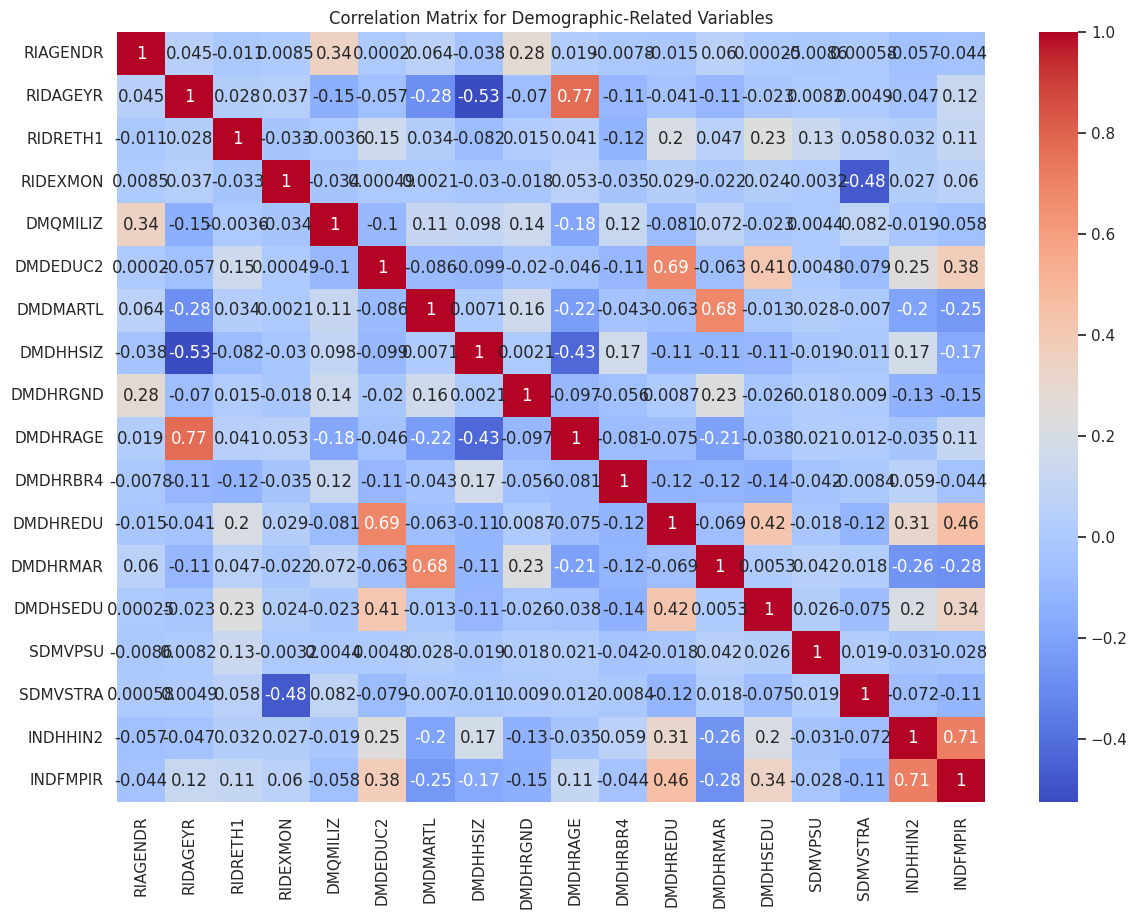

In [ ]:
# Filter numeric columns for each group before computing the correlation matrix

# Diet-related correlation matrix
diet_corr = df_cleaned[diet_columns].select_dtypes(include=['number']).corr()

# Medication-related correlation matrix (filter out non-numeric data)
medication_corr = df_cleaned[medication_columns].select_dtypes(include=['number']).corr()

# Healthcare-related correlation matrix (filter out non-numeric data)
healthcare_corr = df_cleaned[healthcare_columns].select_dtypes(include=['number']).corr()

# Demographic-related correlation matrix
demographic_corr = df_cleaned[demographic_columns].select_dtypes(include=['number']).corr()

# Plotting the correlation matrices

# Diet correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(diet_corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix for Diet-Related Variables')
plt.show()

# Medication correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(medication_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Medication-Related Variables')
plt.show()

# Healthcare correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(healthcare_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Healthcare-Related Variables')
plt.show()

# Demographic correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(demographic_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Demographic-Related Variables')
plt.show()


## Modelling for Model 1

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Step 1: Prepare the Data

# Selecting relevant features and the target variable
features = df_cleaned.drop(columns=['RXDCOUNT'])
target = df_cleaned['RXDCOUNT']

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object', 'category']).columns
numerical_cols = features.select_dtypes(include=['int64', 'float64']).columns

# Define a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=42),
    'SVR': SVR()
}

# Prepare the pipeline for each model using TruncatedSVD for dimensionality reduction
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('svd', TruncatedSVD(n_components=50)),  # Using TruncatedSVD instead of PCA
        ('model', model)
    ])

# Step 2: Train and Evaluate the Models

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Dictionary to store the results
results = {}

# Train and evaluate each model
for name, pipeline in pipelines.items():
    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'R2': r2}

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results).T
results_df.sort_values(by='RMSE', ascending=True, inplace=True)

# Display the results
results_df

RMSE       MSE       MAE        R2
Random Forest      1.162853  1.352227  0.679469  0.854661
XGBoost            1.260035  1.587687  0.830650  0.829353
SVR                1.974540  3.898807  1.226896  0.580951
Gradient Boosting  2.330502  5.431239  1.731907  0.416244
Linear Regression  2.775561  7.703736  2.015786  0.171993

In [ ]:
## Ignore this section of code

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Assuming df_cleaned is available and preprocessed
# Selecting relevant features and the target variable
features = df_cleaned.drop(columns=['RXDCOUNT'])
target = df_cleaned['RXDCOUNT']

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object', 'category']).columns
numerical_cols = features.select_dtypes(include=['int64', 'float64']).columns

# Define a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Prepare the pipeline for each model using TruncatedSVD for dimensionality reduction
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('svd', TruncatedSVD(n_components=50)),
        ('model', model)
    ])

# Reduced grid for Random Forest Regressor
rf_param_grid_reduced = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Reduced grid for XGBoost Regressor
xgb_param_grid_reduced = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.1, 0.2],
    'model__subsample': [0.8],
    'model__colsample_bytree': [1.0]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Set up GridSearchCV for Random Forest with reduced grid
rf_grid_search_reduced = GridSearchCV(
    estimator=pipelines['Random Forest'],
    param_grid=rf_param_grid_reduced,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=3  # Verbose level set to 3 for detailed output
)

# Set up GridSearchCV for XGBoost with reduced grid
xgb_grid_search_reduced = GridSearchCV(
    estimator=pipelines['XGBoost'],
    param_grid=xgb_param_grid_reduced,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=3  # Verbose level set to 3 for detailed output
)

# Perform the grid search for Random Forest with reduced grid
rf_grid_search_reduced.fit(X_train, y_train)
best_rf_model_reduced = rf_grid_search_reduced.best_estimator_

# Perform the grid search for XGBoost with reduced grid
xgb_grid_search_reduced.fit(X_train, y_train)
best_xgb_model_reduced = xgb_grid_search_reduced.best_estimator_

# Evaluate the tuned models on the test set
rf_y_pred_reduced = best_rf_model_reduced.predict(X_test)
xgb_y_pred_reduced = best_xgb_model_reduced.predict(X_test)

# Calculate metrics for Random Forest
rf_rmse_reduced = mean_squared_error(y_test, rf_y_pred_reduced, squared=False)
rf_mse_reduced = mean_squared_error(y_test, rf_y_pred_reduced)
rf_mae_reduced = mean_absolute_error(y_test, rf_y_pred_reduced)
rf_r2_reduced = r2_score(y_test, rf_y_pred_reduced)

# Calculate metrics for XGBoost
xgb_rmse_reduced = mean_squared_error(y_test, xgb_y_pred_reduced, squared=False)
xgb_mse_reduced = mean_squared_error(y_test, xgb_y_pred_reduced)
xgb_mae_reduced = mean_absolute_error(y_test, xgb_y_pred_reduced)
xgb_r2_reduced = r2_score(y_test, xgb_y_pred_reduced)

# Store the results
tuned_results_reduced = {
    'Tuned Random Forest (Reduced)': {'RMSE': rf_rmse_reduced, 'MSE': rf_mse_reduced, 'MAE': rf_mae_reduced, 'R2': rf_r2_reduced},
    'Tuned XGBoost (Reduced)': {'RMSE': xgb_rmse_reduced, 'MSE': xgb_mse_reduced, 'MAE': xgb_mae_reduced, 'R2': xgb_r2_reduced}
}

# Convert results to DataFrame for easy comparison
tuned_results_reduced_df = pd.DataFrame(tuned_results_reduced).T

# Display the results
tuned_results_reduced_df


Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 

## Model 2

In [ ]:
# Check unique values in the RXDRSC1 column
unique_values = df_cleaned['RXDRSC1'].unique()
unique_values_count = len(unique_values)

In [ ]:
# Let's group the data by the new 'Target' variable and count the instances for each category.
category_counts = df_cleaned['RXDRSC1'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']
category_counts

Category  Count
0        I10   8274
1      E78.0   1134
2        E11    903
3        J45    530
4      F32.9    474
..       ...    ...
461    L57.8      1
462    F11.2      1
463      L55      1
464    E87.8      1
465    K12.0      1

[466 rows x 2 columns]

In [ ]:
# Define the values that should be labeled as 1
condition_values = ['I51.9', 'I50.9', 'R12', 'E11', 'E11.2', 'E11.4','I10']

# Create the binary target variable
df_cleaned['Target'] = df_cleaned['RXDRSC1'].apply(lambda x: 1 if x in condition_values else 0)

# Display the distribution of the new target variable
target_distribution = df_cleaned['Target'].value_counts()

target_distribution

Target
0    10137
1     9423
Name: count, dtype: int64

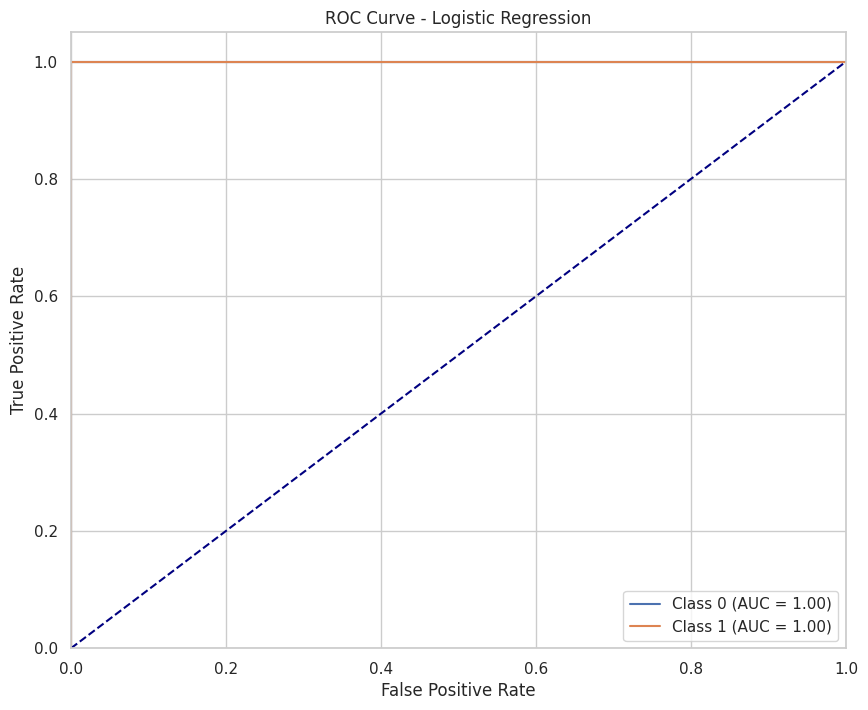

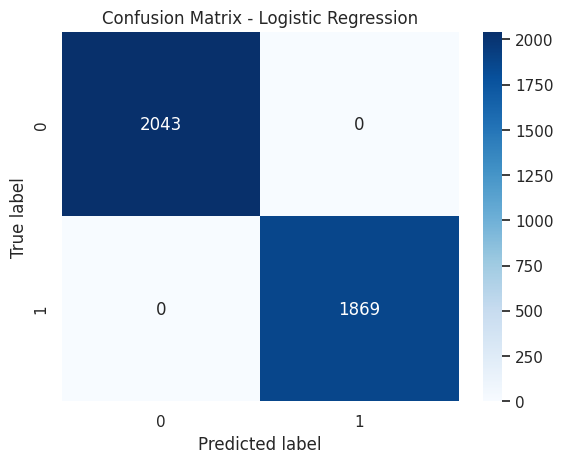

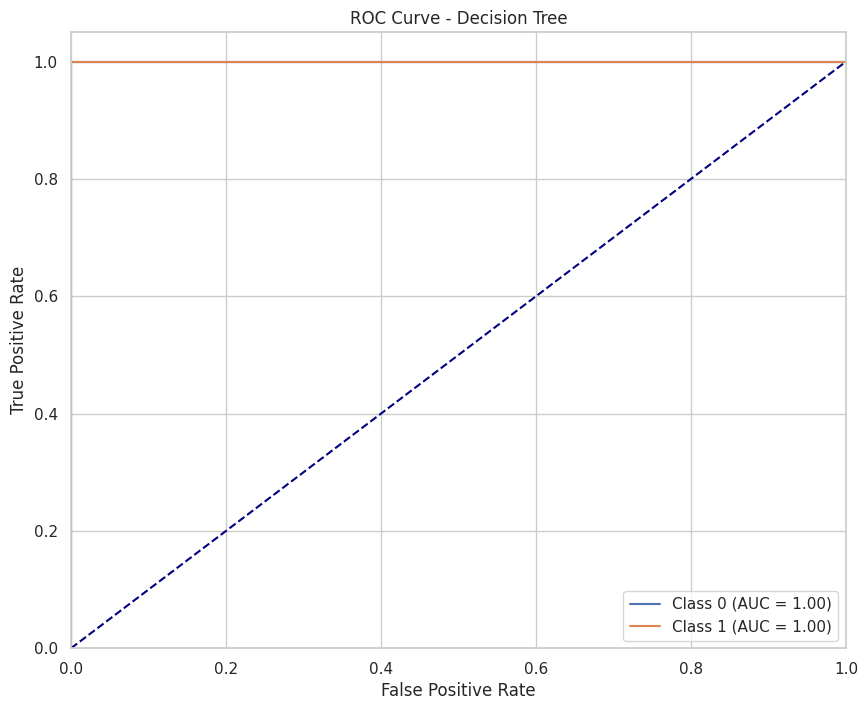

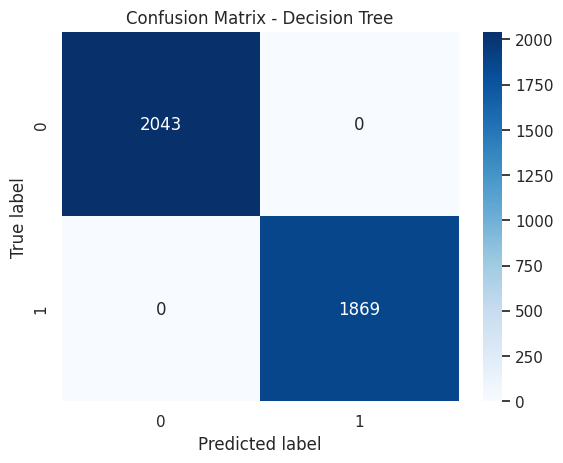

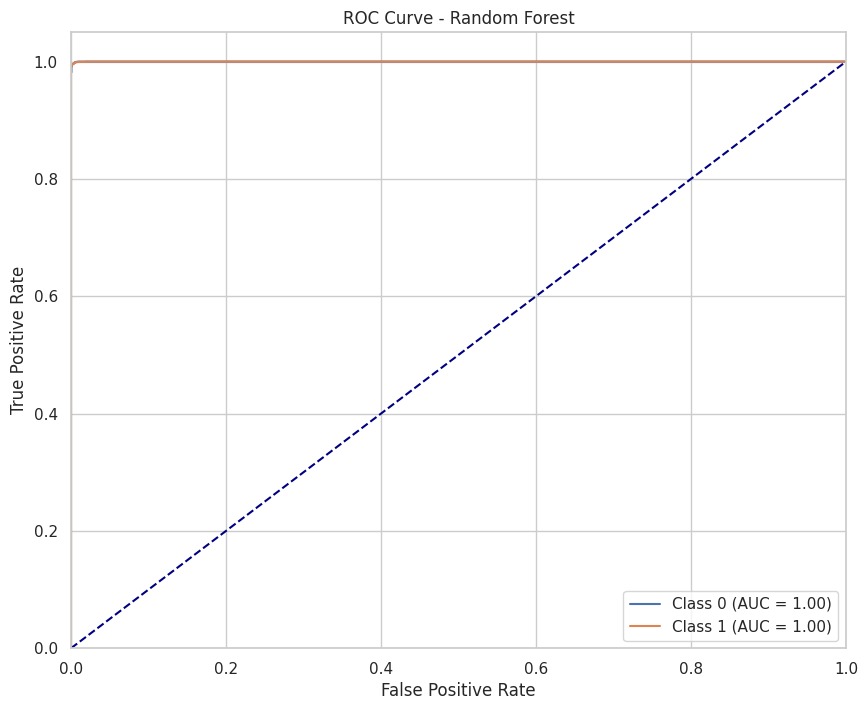

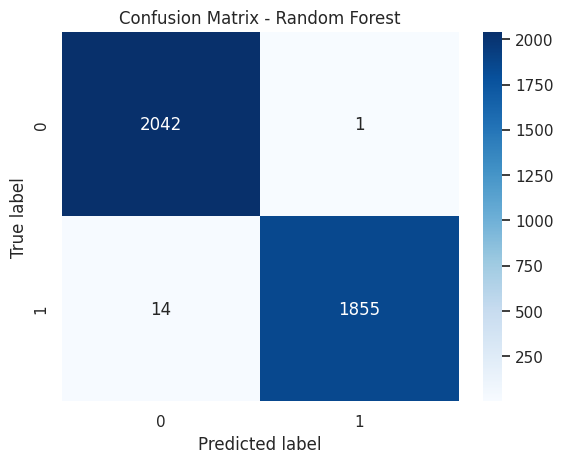

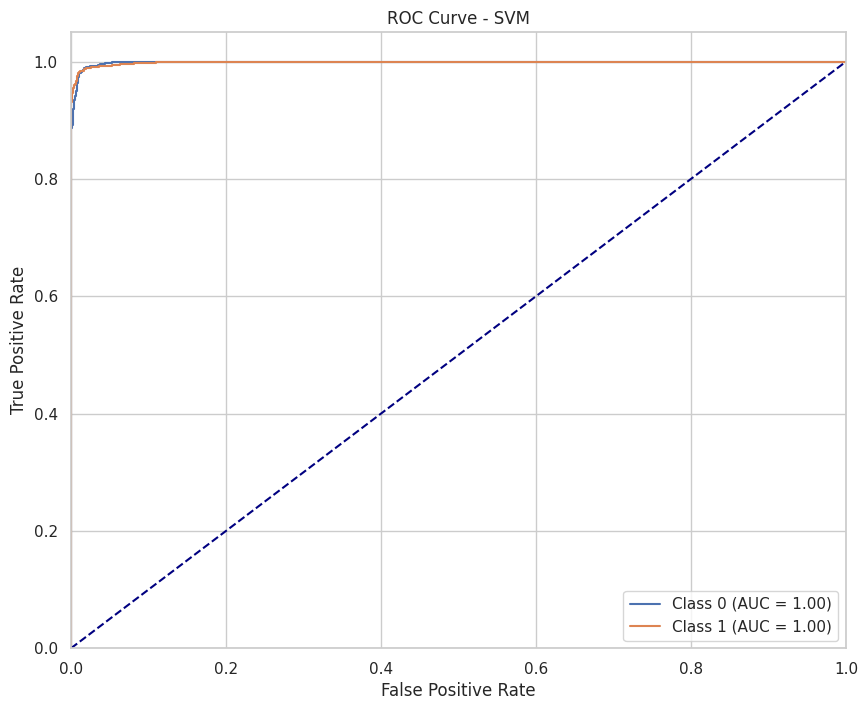

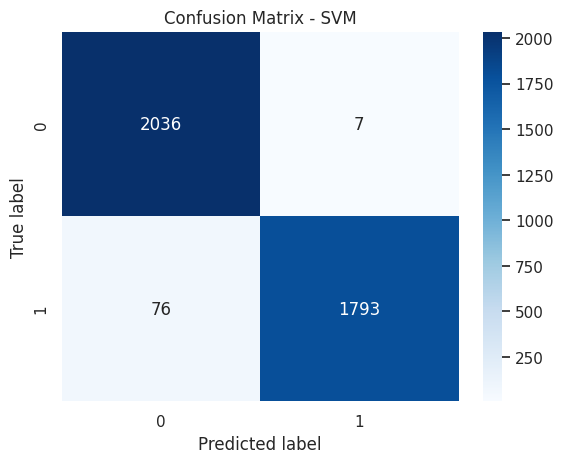

0  \
Logistic Regression  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Decision Tree        {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Random Forest        {'precision': 0.9931906614785992, 'recall': 0....   
SVM                  {'precision': 0.9640151515151515, 'recall': 0....   

                                                                     1  \
Logistic Regression  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Decision Tree        {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Random Forest        {'precision': 0.9994612068965517, 'recall': 0....   
SVM                  {'precision': 0.9961111111111111, 'recall': 0....   

                     accuracy  \
Logistic Regression  1.000000   
Decision Tree        1.000000   
Random Forest        0.996166   
SVM                  0.978783   

                                                             macro avg  \
Logistic Regression  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Decision Tree        {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Random Forest        {'precision': 0.9963259341875754, 'recall': 0....   
SVM                  {'precision': 0.9800631313131313, 'recall': 0....   

                                                          weighted avg  
Logistic Regression  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...  
Decision Tree        {'precision': 1.0, 'recall': 1.0, 'f1-score': ...  
Random Forest        {'precision': 0.9961864818738326, 'recall': 0....  
SVM                  {'precision': 0.9793493408006444, 'recall': 0....

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_cleaned is available and preprocessed
# Selecting relevant features and the target variable for classification
features = df_cleaned.drop(columns=['Target'])
target = df_cleaned['Target']

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object', 'category']).columns
numerical_cols = features.select_dtypes(include=['int64', 'float64']).columns

# Define a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the models with increased max_iter for Logistic Regression
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Store the results
results = {}
roc_curves = {}

for name, model in models.items():
    # For Logistic Regression and SVM, use OneVsRestClassifier for multiclass ROC AUC
    if name in ['Logistic Regression', 'SVM']:
        model = OneVsRestClassifier(model)

    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results[name] = report

    # ROC Curve and AUC (for each class in multiclass setting)
    y_pred_proba = pipeline.predict_proba(X_test)
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 8))
    for i in range(y_test.nunique()):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Plot the ROC curve for the current model
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Convert results to DataFrame for easy comparison
classification_reports_df = pd.DataFrame(results).T

# Flatten the nested classification report dictionary for a cleaner DataFrame
classification_reports_df = classification_reports_df.apply(lambda x: pd.Series(x), axis=1)

# Display the classification reports
classification_reports_df

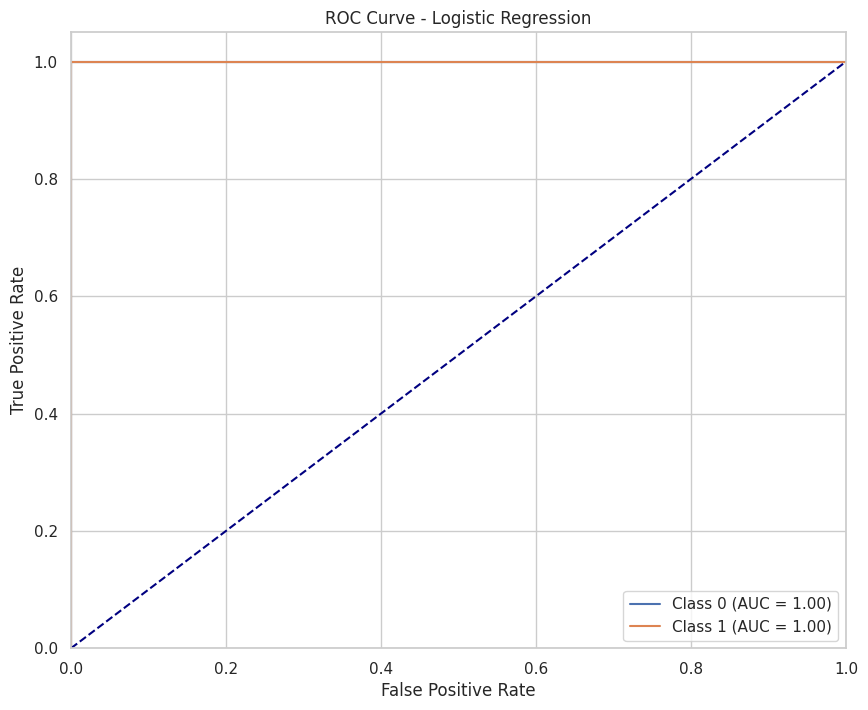

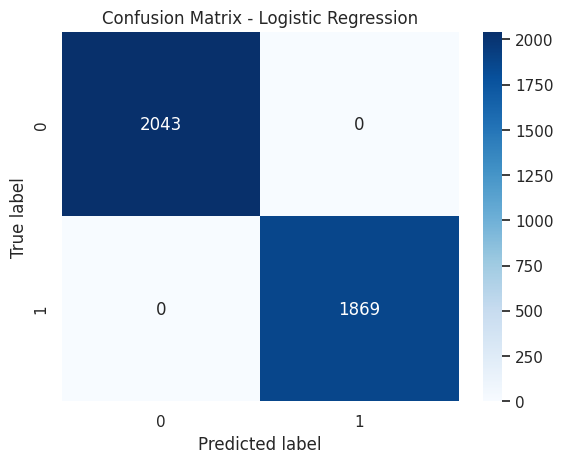

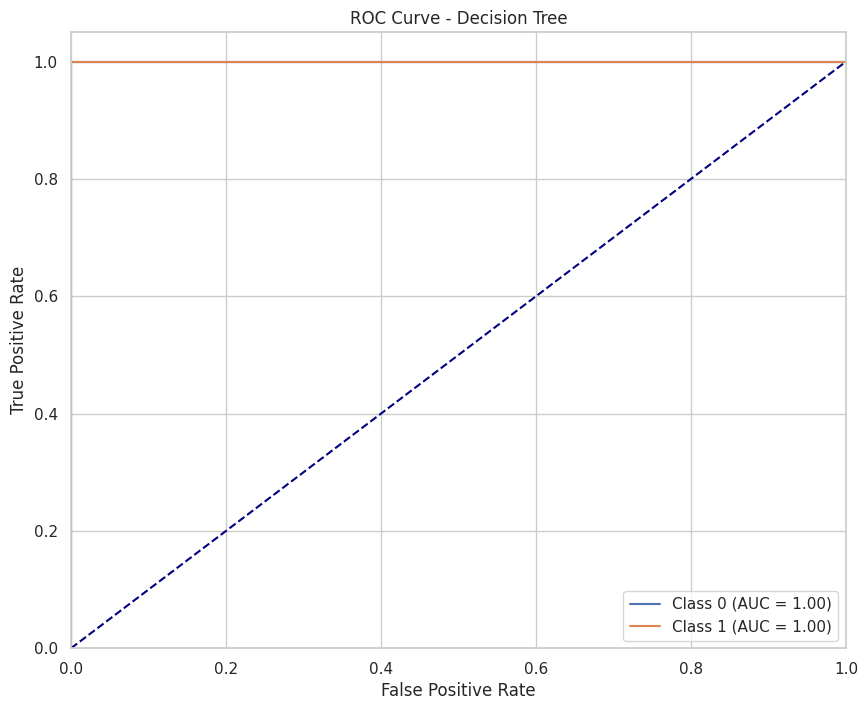

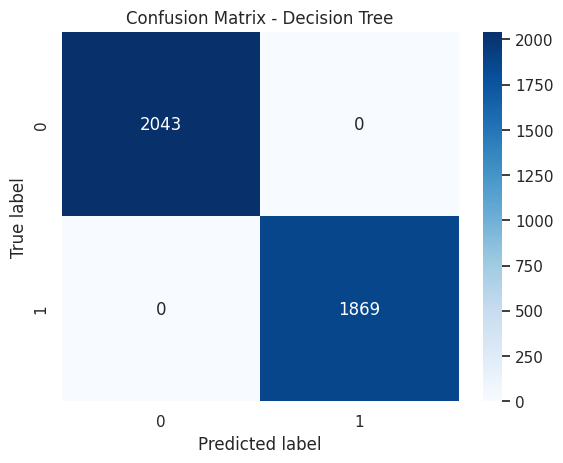

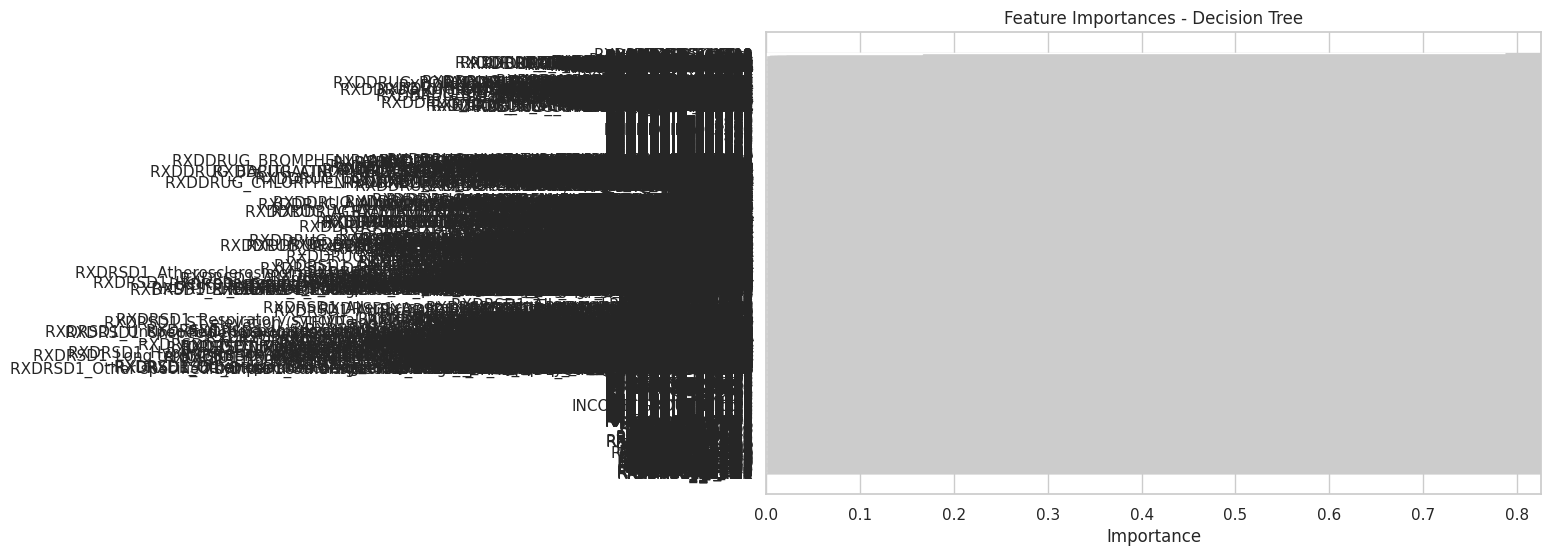

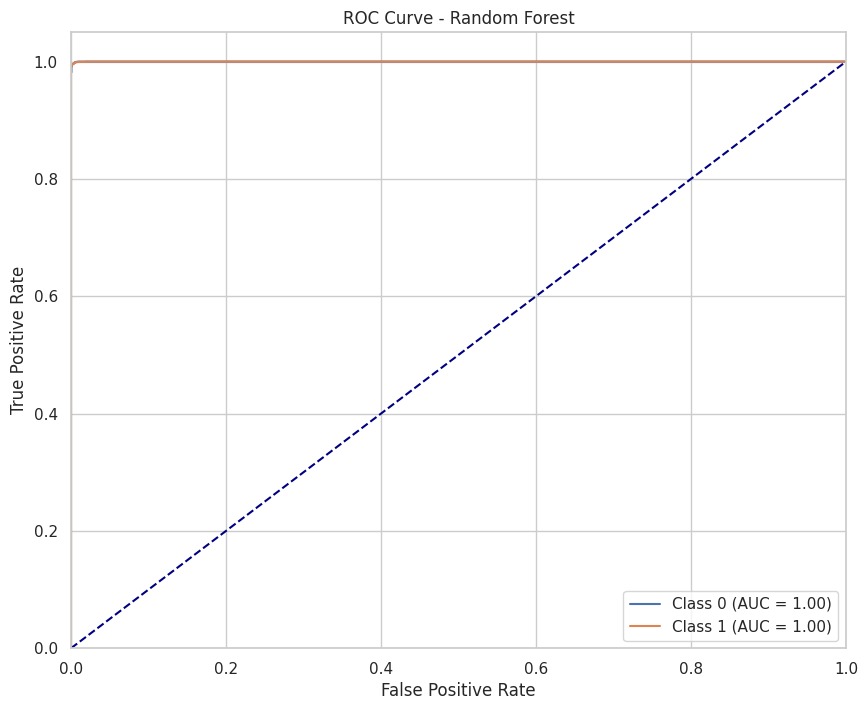

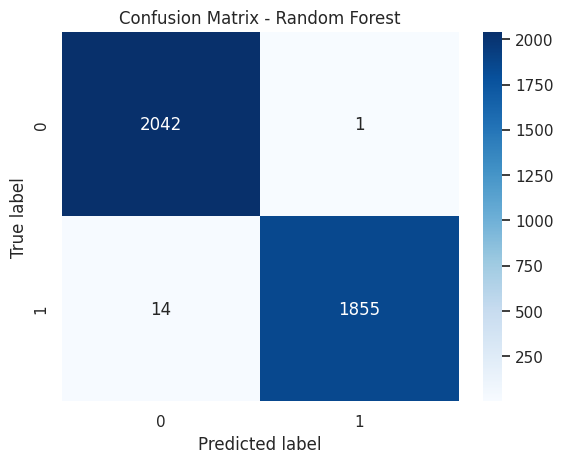

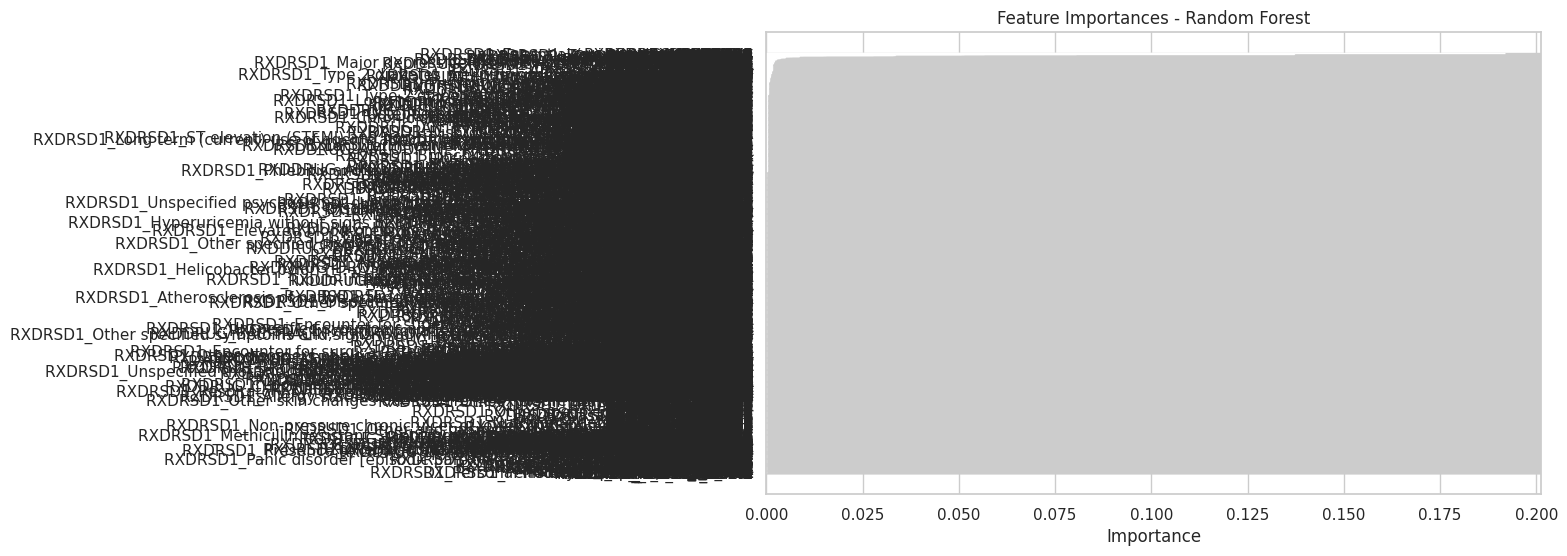

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df_cleaned is available and preprocessed
# Selecting relevant features and the target variable for classification
features = df_cleaned.drop(columns=['Target'])
target = df_cleaned['Target']

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object', 'category']).columns
numerical_cols = features.select_dtypes(include=['int64', 'float64']).columns

# Define a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the models with increased max_iter for Logistic Regression
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Store the results
results = {}
roc_curves = {}

for name, model in models.items():
    # For Logistic Regression and SVM, use OneVsRestClassifier for multiclass ROC AUC
    if name in ['Logistic Regression', 'SVM']:
        model = OneVsRestClassifier(model)

    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results[name] = report

    # ROC Curve and AUC (for each class in multiclass setting)
    y_pred_proba = pipeline.predict_proba(X_test)
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 8))
    for i in range(y_test.nunique()):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Plot the ROC curve for the current model
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Feature Importance for models that support it
    if hasattr(model, 'feature_importances_') or hasattr(model, 'coef_'):
        if hasattr(model, 'feature_importances_'):
            # Decision Tree and Random Forest
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Logistic Regression (use the absolute value of coefficients)
            importance = np.mean(np.abs(model.coef_), axis=0)

        # Get feature names after one-hot encoding
        feature_names = list(preprocessor.named_transformers_['num'].get_feature_names_out(numerical_cols))
        feature_names += list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

        # Sort the feature importances in descending order
        indices = np.argsort(importance)[::-1]
        sorted_importances = importance[indices]
        sorted_feature_names = np.array(feature_names)[indices]

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances - {name}')
        plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
        plt.yticks(range(len(sorted_importances)), sorted_feature_names)
        plt.gca().invert_yaxis()
        plt.xlabel('Importance')
        plt.show()

# Convert results to DataFrame for easy comparison
classification_reports_df = pd.DataFrame(results).T

# Flatten the nested classification report dictionary for a cleaner DataFrame
classification_reports_df = classification_reports_df.apply(lambda x: pd.Series(x), axis=1)

# Display the classification reports
classification_reports_df

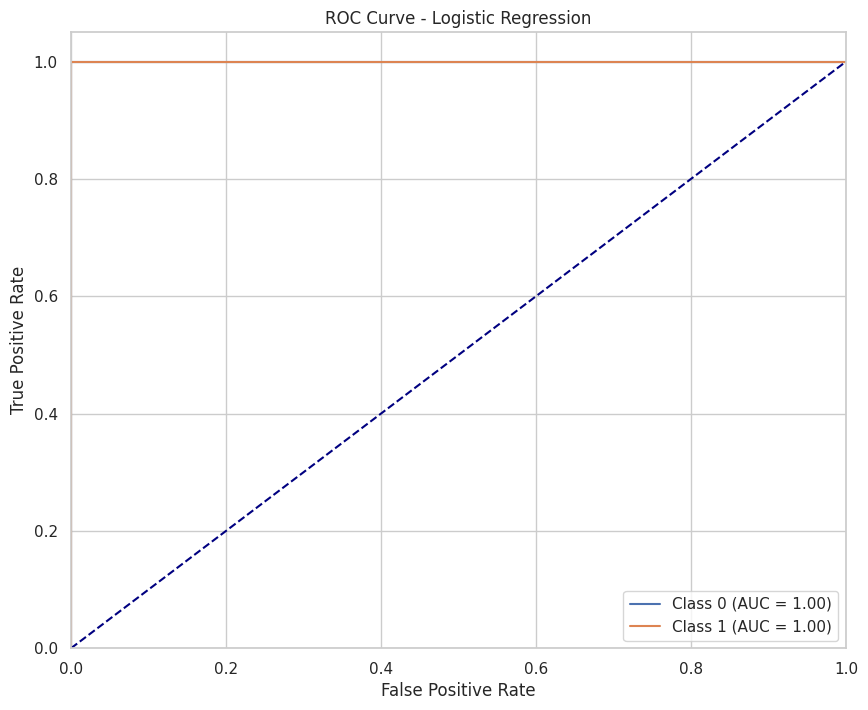

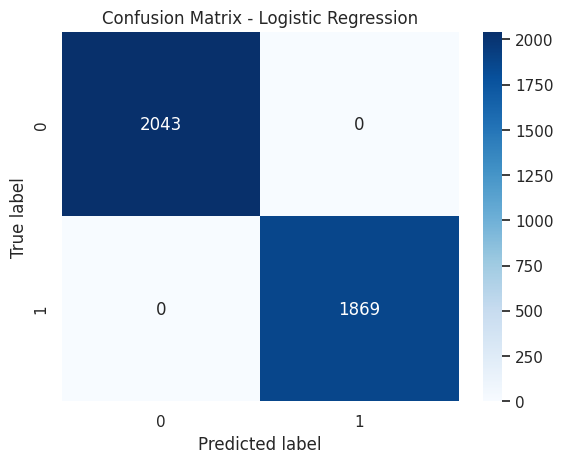

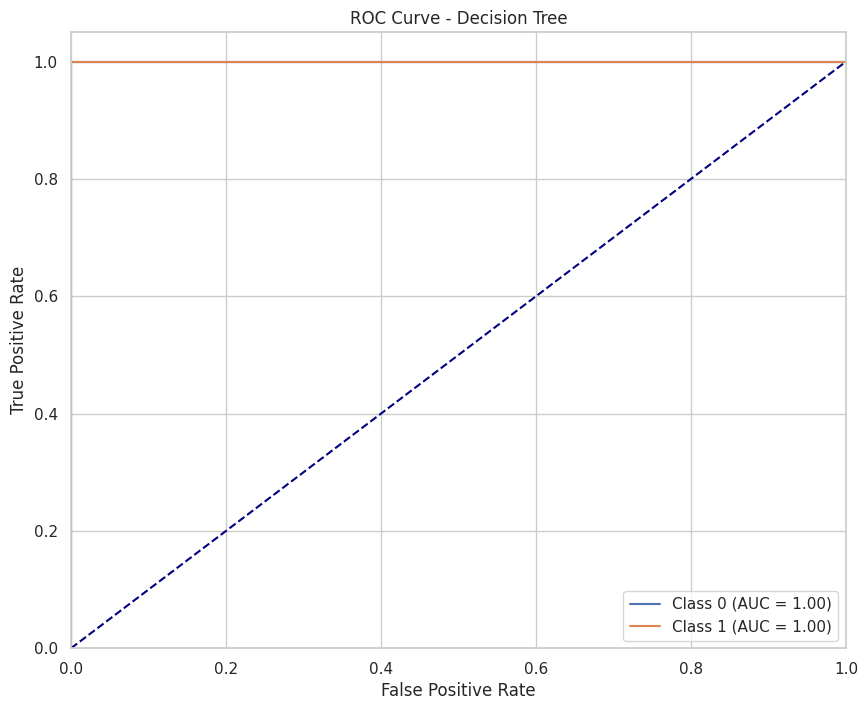

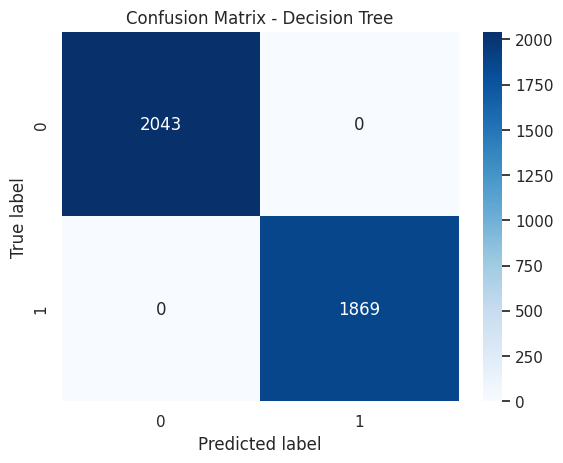

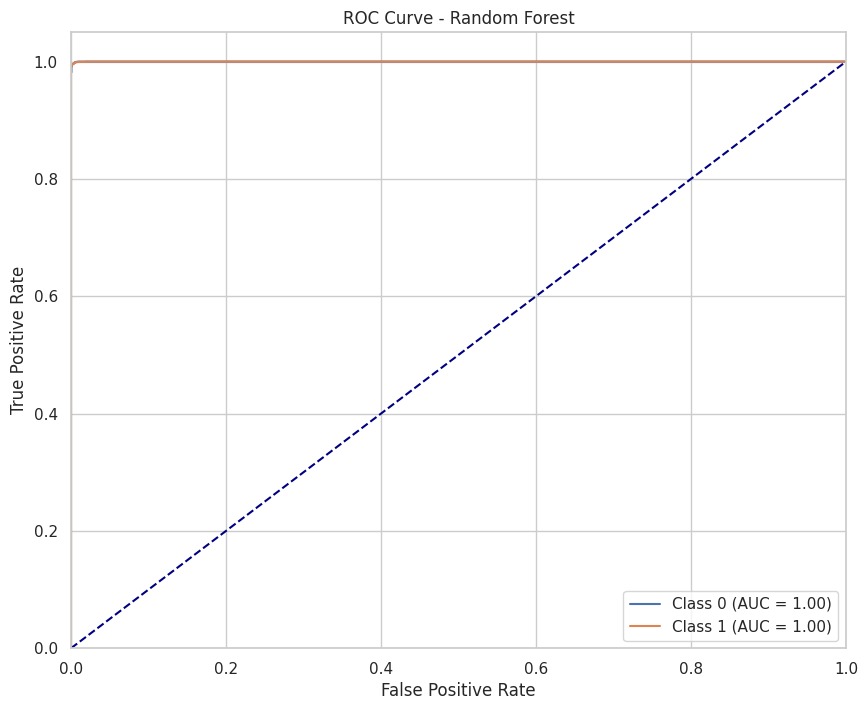

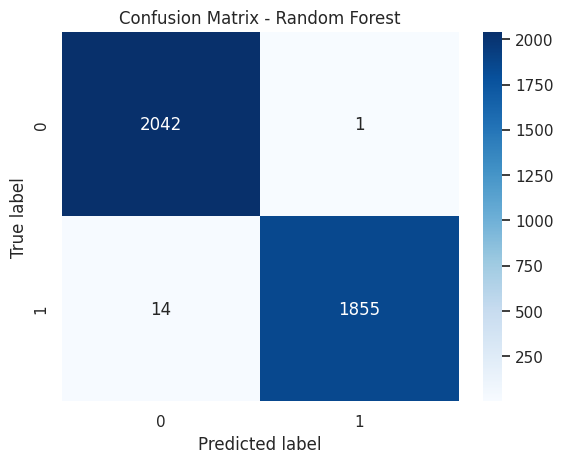

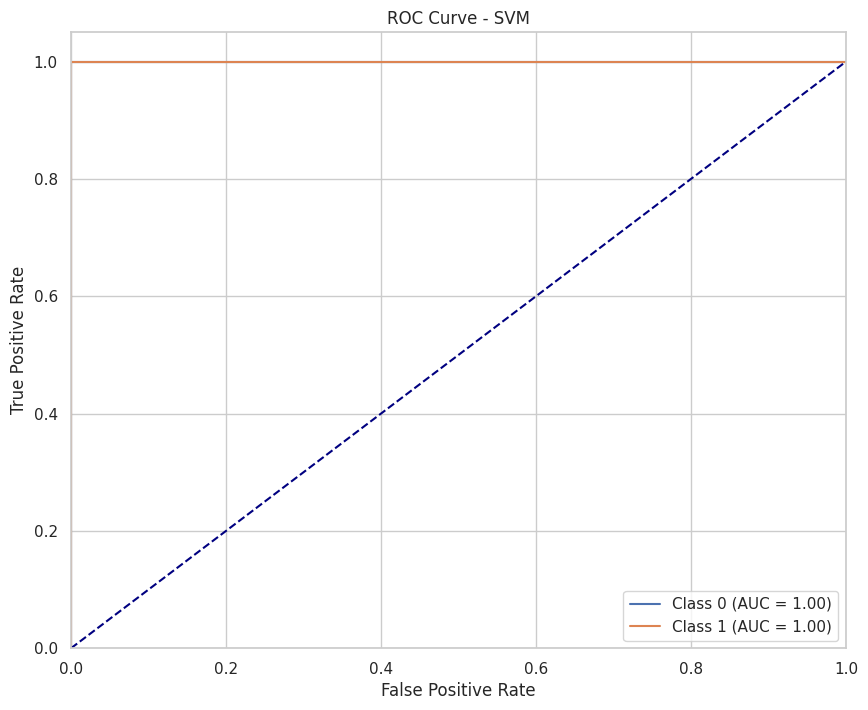

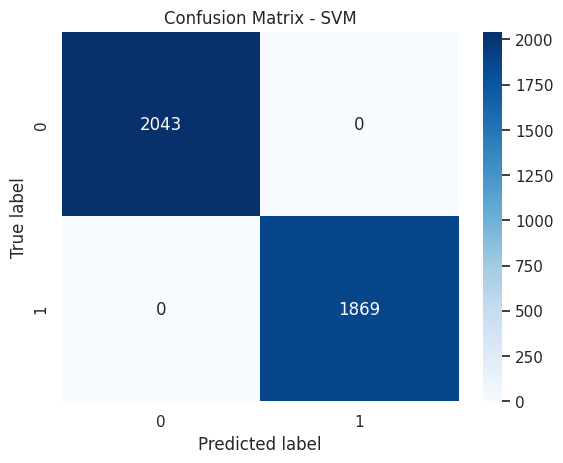

Model: Logistic Regression

Top 10 Important Features for medication:

RXDRSD1_Prophylactic medication: -0.0663


Top 10 Important Features for diet:



Top 10 Important Features for healthcare:



Top 10 Important Features for demographics:



Model: Decision Tree

Top 10 Important Features for medication:

RXDRSD1_Prophylactic medication: 0.0000


Top 10 Important Features for diet:



Top 10 Important Features for healthcare:



Top 10 Important Features for demographics:



Model: Random Forest

Top 10 Important Features for medication:

RXDRSD1_Prophylactic medication: 0.0000


Top 10 Important Features for diet:



Top 10 Important Features for healthcare:



Top 10 Important Features for demographics:



Model: SVM

Top 10 Important Features for medication:

RXDRSD1_Prophylactic medication: -0.0351


Top 10 Important Features for diet:



Top 10 Important Features for healthcare:



Top 10 Important Features for demographics:





0  \
Logistic Regression  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Decision Tree        {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Random Forest        {'precision': 0.9931906614785992, 'recall': 0....   
SVM                  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   

                                                                     1  \
Logistic Regression  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Decision Tree        {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Random Forest        {'precision': 0.9994612068965517, 'recall': 0....   
SVM                  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   

                     accuracy  \
Logistic Regression       1.0   
Decision Tree             1.0   
Random Forest        0.996166   
SVM                       1.0   

                                                             macro avg  \
Logistic Regression  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Decision Tree        {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
Random Forest        {'precision': 0.9963259341875754, 'recall': 0....   
SVM                  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   

                                                          weighted avg  
Logistic Regression  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...  
Decision Tree        {'precision': 1.0, 'recall': 1.0, 'f1-score': ...  
Random Forest        {'precision': 0.9961864818738326, 'recall': 0....  
SVM                  {'precision': 1.0, 'recall': 1.0, 'f1-score': ...

In [ ]:
# Adjusted code
for name, model in models.items():
    # For Logistic Regression and SVM, use OneVsRestClassifier for multiclass ROC AUC
    if name in ['Logistic Regression', 'SVM']:
        model = OneVsRestClassifier(model)

    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results[name] = report

    # Feature importance extraction
    if name in ['Decision Tree', 'Random Forest']:
        importances = model.feature_importances_
    elif name in ['SVM', 'Logistic Regression']:
        # Extract coefficients, convert to dense if sparse
        importances = np.mean([est.coef_.toarray()[0] if hasattr(est.coef_, "toarray") else est.coef_[0] for est in model.estimators_], axis=0)

    # Retrieve feature names after preprocessing
    feature_names = numerical_cols.tolist() + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))
    feature_importance_dict = dict(zip(feature_names, importances))
    feature_importances[name] = feature_importance_dict

    # ROC Curve and AUC (for each class in multiclass setting)
    y_pred_proba = pipeline.predict_proba(X_test)
    fpr = {}
    tpr = {}
    roc_auc = {}
    plt.figure(figsize=(10, 8))
    for i in range(y_test.nunique()):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Plot the ROC curve for the current model
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Convert results to DataFrame for easy comparison
classification_reports_df = pd.DataFrame(results).T

# Function to display top 10 important features for a category
def display_top_10_features(importances, category):
    filtered_importances = {k: v for k, v in importances.items() if category in k}
    top_10_features = dict(sorted(filtered_importances.items(), key=lambda item: item[1], reverse=True)[:10])
    print(f"Top 10 Important Features for {category}:\n")
    for feature, importance in top_10_features.items():
        print(f"{feature}: {importance:.4f}")
    print("\n")

# Display top 10 important features for each category
categories = ['medication', 'diet', 'healthcare', 'demographics']
for name, importances in feature_importances.items():
    print(f"Model: {name}\n")
    for category in categories:
        display_top_10_features(importances, category)
    print("="*50)

# Display the classification reports
classification_reports_df


Top 10 Important Features for medication:
   feature  importance
2  RXDDAYS    0.051208
0   RXDUSE    0.050538
1  RXQSEEN    0.033357

Top 10 Important Features for diet:
     feature  importance
38  DR1TCAFF    0.002238
3   DR1TSUGR    0.001937
10   DR1TRET    0.001750
1   DR1TPROT    0.001701
4   DR1TFIBE    0.001687
6   DR1TPFAT    0.001622
21  DR1TFOLA    0.001574
0   DR1TKCAL    0.001572
31  DR1TPHOS    0.001564
2   DR1TCARB    0.001560

Top 10 Important Features for healthcare:
    feature  importance
0  RXDCOUNT    0.015536

Top 10 Important Features for demographics:
     feature  importance
9   DMDHRAGE    0.009385
1   RIDAGEYR    0.008505
7   DMDHHSIZ    0.004739
4   DMQMILIZ    0.002854
5   DMDEDUC2    0.002090
10  DMDHRBR4    0.002061
6   DMDMARTL    0.001968
17  INDFMPIR    0.001497
15  SDMVSTRA    0.001451
2   RIDRETH1    0.001440


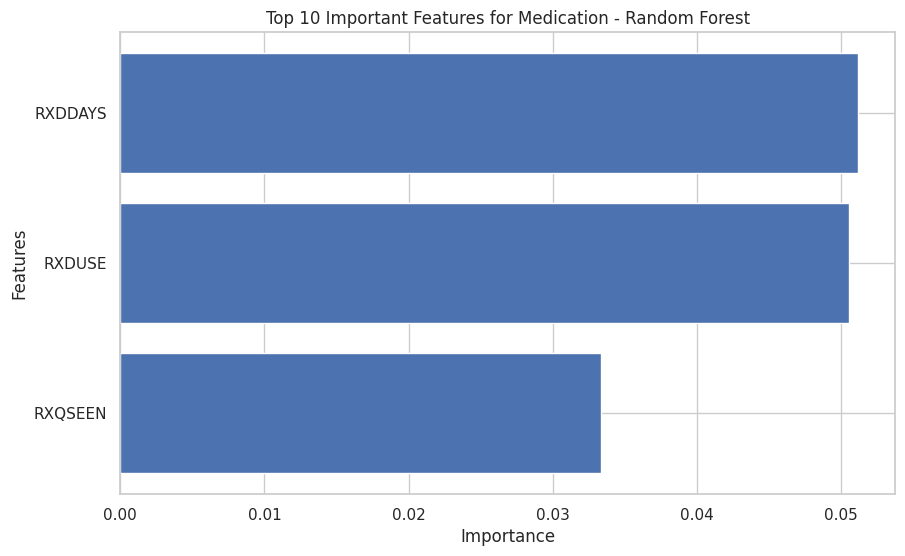

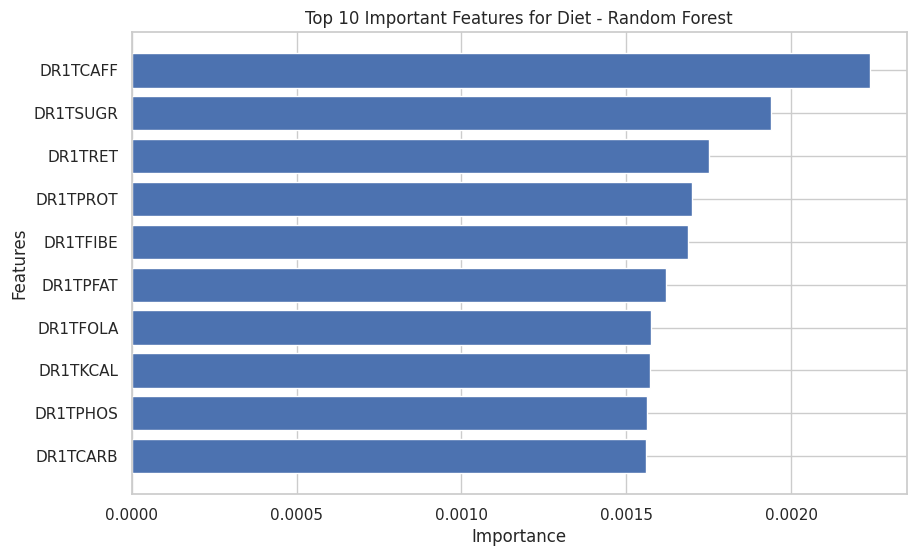

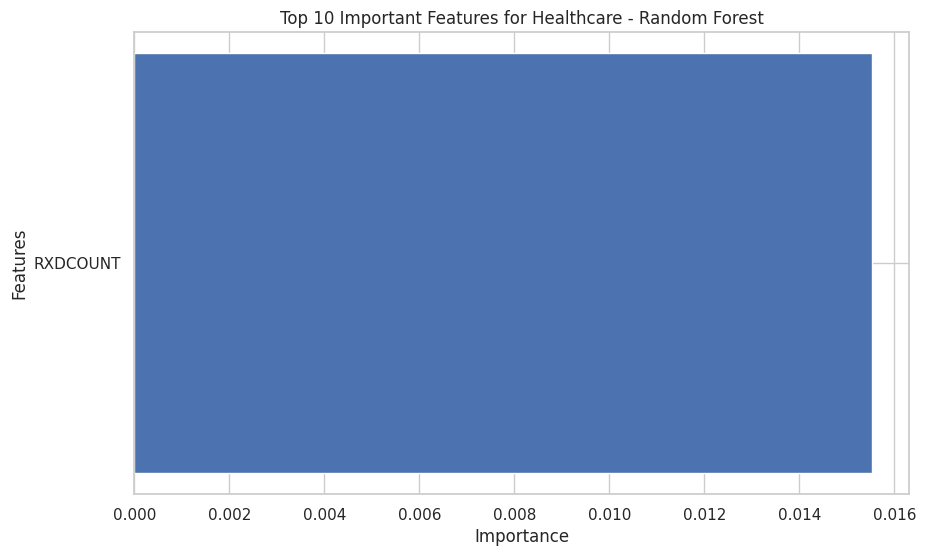

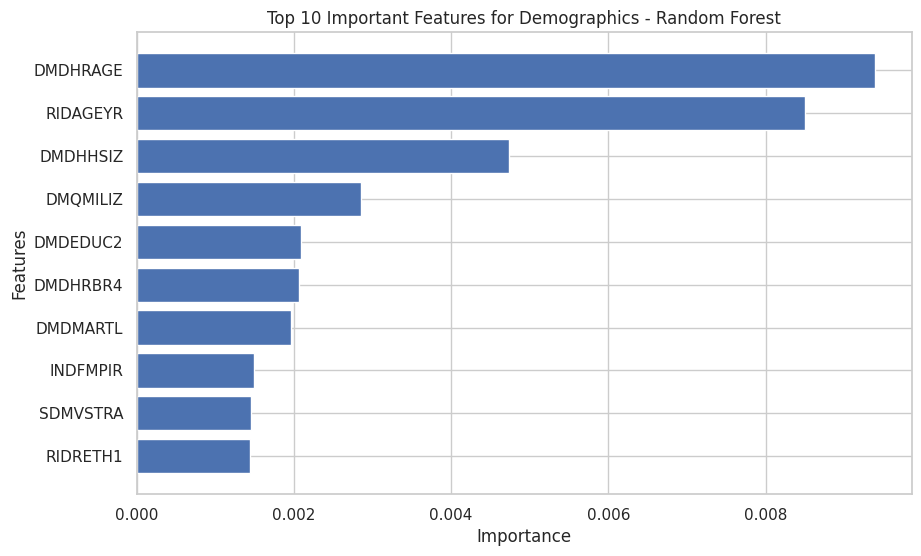

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to get the top 10 important features for each group
def get_top_10_features(importances, feature_names, group_columns):
    valid_features = [col for col in group_columns if col in feature_names]
    valid_importances = [importances[feature_names.index(col)] for col in valid_features]
    feature_importance_df = pd.DataFrame({'feature': valid_features, 'importance': valid_importances})
    top_10 = feature_importance_df.sort_values(by='importance', ascending=False).head(10)
    return top_10

# Train the Random Forest model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models['Random Forest'])])
pipeline.fit(X_train, y_train)
trained_model = pipeline.named_steps['model']

# Extract the feature importances
importances = trained_model.feature_importances_

# Retrieve feature names after preprocessing
feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(numerical_cols).tolist() + \
                pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols).tolist()

# Get the top 10 important features for each group
print("Top 10 Important Features for medication:")
medication_importances = get_top_10_features(importances, feature_names, medication_columns)
print(medication_importances)

print("\nTop 10 Important Features for diet:")
diet_importances = get_top_10_features(importances, feature_names, diet_columns)
print(diet_importances)

print("\nTop 10 Important Features for healthcare:")
healthcare_importances = get_top_10_features(importances, feature_names, healthcare_columns)
print(healthcare_importances)

print("\nTop 10 Important Features for demographics:")
demographic_importances = get_top_10_features(importances, feature_names, demographic_columns)
print(demographic_importances)

# Visualization of the top 10 important features for each group
for group, importance_df in zip(
        ['Medication', 'Diet', 'Healthcare', 'Demographics'],
        [medication_importances, diet_importances, healthcare_importances, demographic_importances]
    ):
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'Top 10 Important Features for {group} - Random Forest')
    plt.gca().invert_yaxis()
    plt.show()
